# DARTS
Examples of DARTS (https://github.com/unit8co/darts) library usage.

Examples are taken from https://github.com/unit8co/darts/blob/master/examples, adding some minor modifications.

In [ ]:
!pip install darts
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.4/819.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2

# 1. Quickstart


In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import AirPassengersDataset

## 1.1. Data visualization

<Axes: xlabel='Month'>

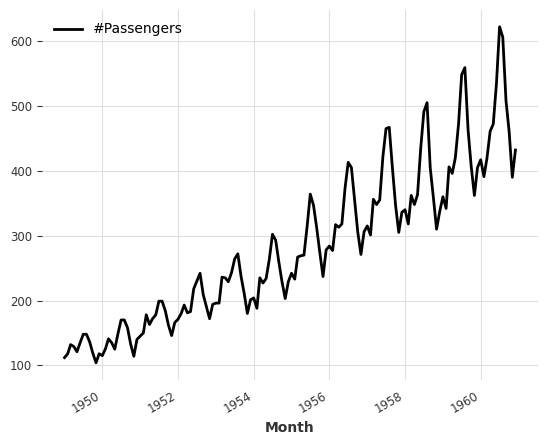

In [ ]:
# Load data
series = AirPassengersDataset().load()
series.plot()

In [ ]:
# Show object structure
series.head(2)

<TimeSeries (DataArray) (Month: 2, component: 1, sample: 1)>
array([[[112.]],

       [[118.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1949-01-01 1949-02-01
  * component  (component) object '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='Month'>

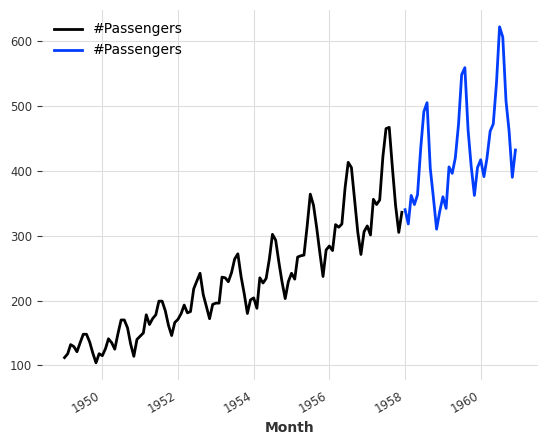

In [ ]:
series1, series2 = series.split_after(0.75)
series1.plot()
series2.plot()

<Axes: xlabel='Month'>

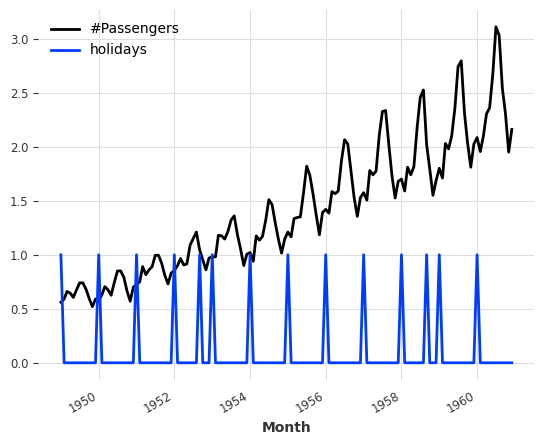

In [ ]:
(series / 200).add_holidays("US").plot()

<Axes: xlabel='time'>

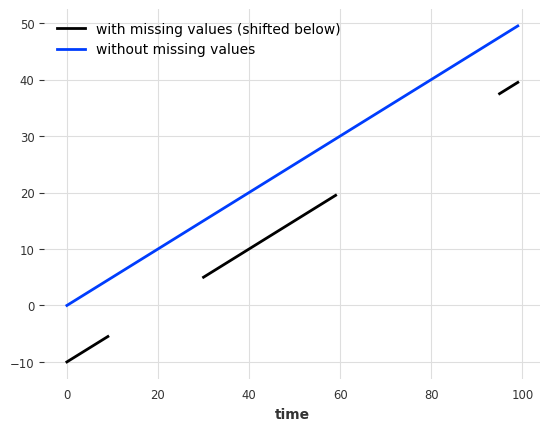

In [ ]:
from darts.utils.missing_values import fill_missing_values

values = np.arange(50, step=0.5)
values[10:30] = np.nan
values[60:95] = np.nan
series_ = TimeSeries.from_values(values)

(series_ - 10).plot(label="with missing values (shifted below)")
fill_missing_values(series_).plot(label="without missing values")

## 1.2. Baseline models

<Axes: xlabel='Month'>

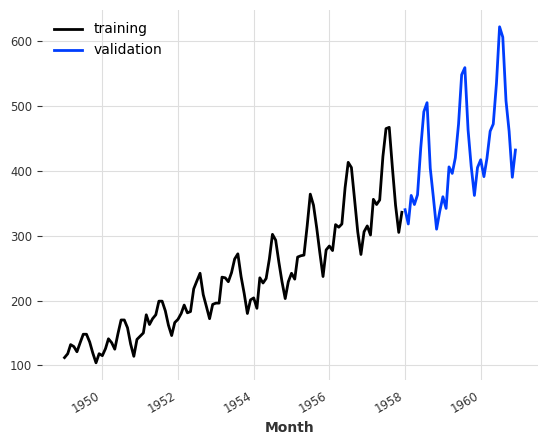

In [ ]:
train, val = series.split_before(pd.Timestamp("19580101"))
train.plot(label="training")
val.plot(label="validation")

In [ ]:
display(train.head(2))

<TimeSeries (DataArray) (Month: 2, component: 1, sample: 1)>
array([[[112.]],

       [[118.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1949-01-01 1949-02-01
  * component  (component) object '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='Month'>

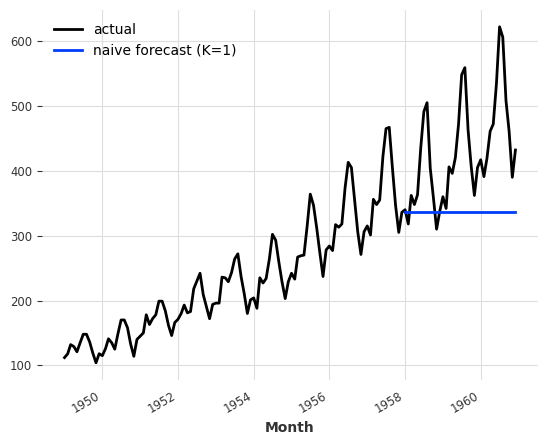

In [ ]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(36)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

There is seasonality of order 12.


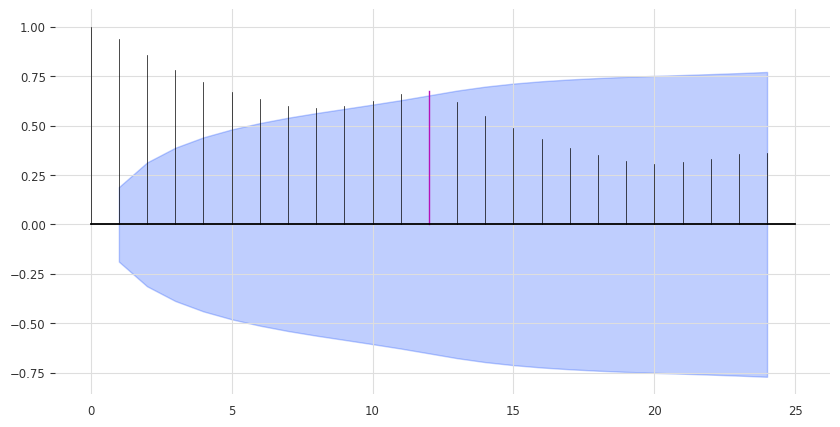

In [ ]:
# Inspect seasonality & improve model baseline
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=12, alpha=0.05)

k = 1
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))
        k = period

<Axes: xlabel='Month'>

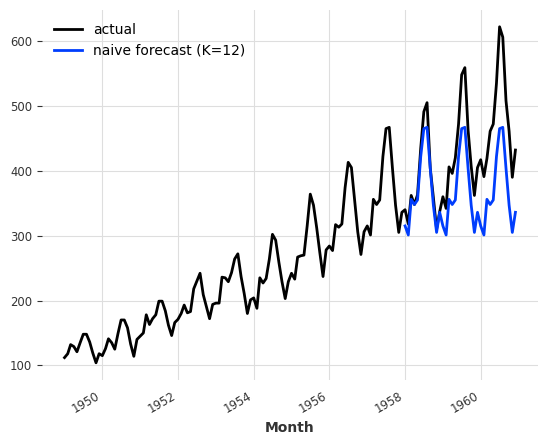

In [ ]:
seasonal_model = NaiveSeasonal(K=k)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

series.plot(label="actual")
seasonal_forecast.plot(label=f"naive forecast (K={k})")

<Axes: xlabel='Month'>

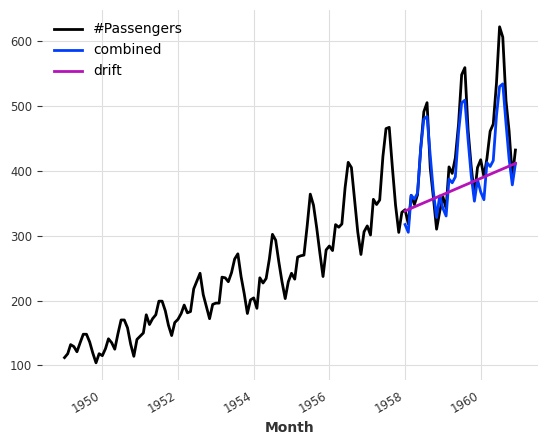

In [ ]:
# Improve baseline - Include Trend
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

In [ ]:
# Error metrics
from darts.metrics import mape

print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        mape(series, combined_forecast)
    )
)

Mean absolute percentage error for the combined naive drift + seasonal: 5.66%.


In [ ]:
# Try other models
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta

def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

model ExponentialSmoothing() obtains MAPE: 5.11%
model TBATS() obtains MAPE: 5.87%
model AutoARIMA() obtains MAPE: 11.65%
model Theta() obtains MAPE: 8.15%


The MAPE is: 4.40, with theta = -3.5102040816326543.


<Axes: xlabel='Month'>

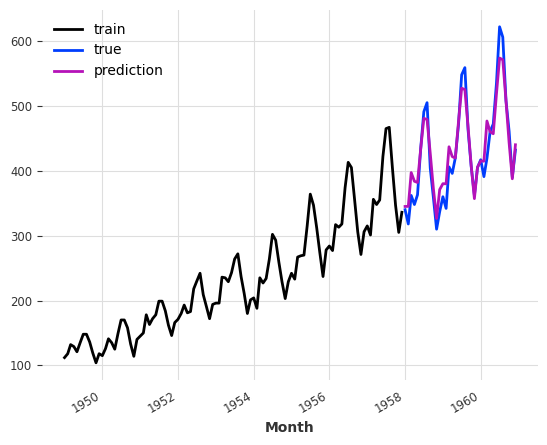

In [ ]:
# Hyperparameter search

# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

# Eval model
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(val, pred_best_theta), best_theta
    )
)

# Plot results
train.plot(label="train")
val.plot(label="true")
pred_best_theta.plot(label="prediction")

100%|██████████| 57/57 [00:03<00:00, 17.88it/s]


MAPE = 7.70%


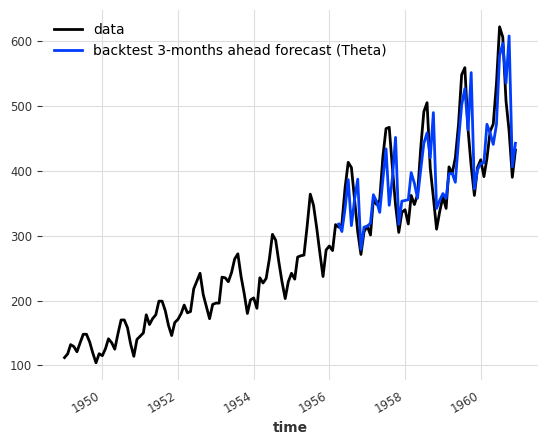

In [ ]:
# Backtesting: performance we would have obtained if we had been using this model historically

historical_fcast_theta = best_theta_model.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_theta.plot(label="backtest 3-months ahead forecast (Theta)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_theta, series)))

100%|██████████| 57/57 [00:01<00:00, 42.88it/s]


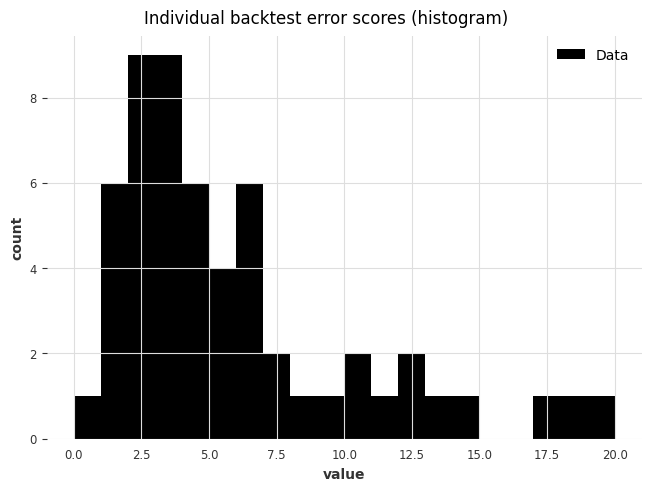

In [ ]:
best_theta_model = Theta(best_theta)

raw_errors = best_theta_model.backtest(
    series, start=0.6, forecast_horizon=3, metric=mape, reduction=None, verbose=True
)

from darts.utils.statistics import plot_hist

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
)

100%|██████████| 57/57 [00:05<00:00, 10.72it/s]


MAPE = 4.45%


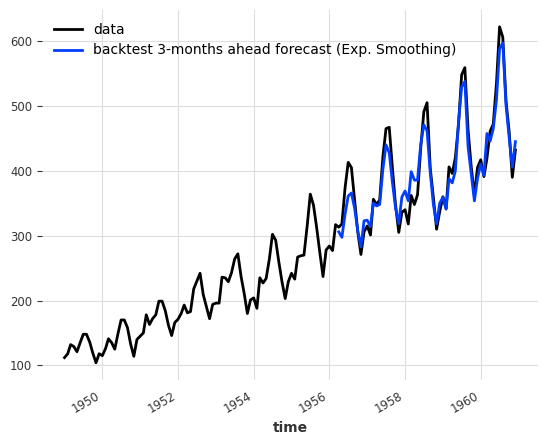

In [ ]:
# Trying another model
model_es = ExponentialSmoothing(seasonal_periods=12)
historical_fcast_es = model_es.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_es.plot(label="backtest 3-months ahead forecast (Exp. Smoothing)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_es, series)))

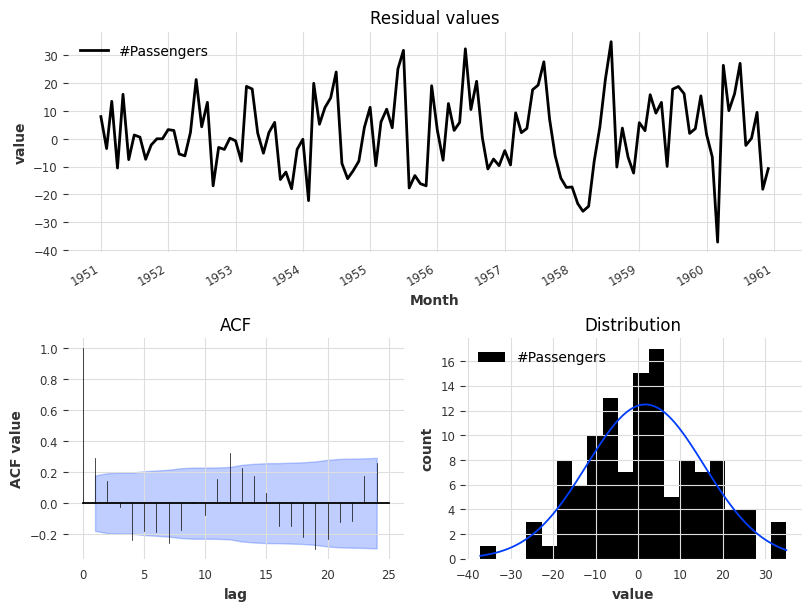

In [ ]:
from darts.utils.statistics import plot_residuals_analysis

plot_residuals_analysis(model_es.residuals(series))

## 1.3. ML models

<Axes: xlabel='Month'>

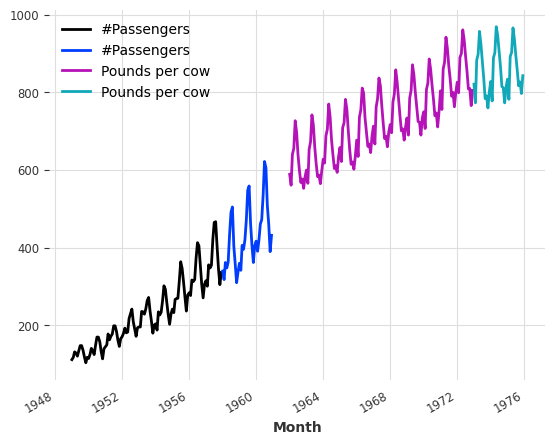

In [ ]:
# Get two time series

from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

series_air = AirPassengersDataset().load().astype(np.float32)
series_milk = MonthlyMilkDataset().load().astype(np.float32)

# set aside last 36 months of each series as validation set:
train_air, val_air = series_air[:-36], series_air[-36:]
train_milk, val_milk = series_milk[:-36], series_milk[-36:]

train_air.plot()
val_air.plot()
train_milk.plot()
val_milk.plot()

<Axes: xlabel='Month'>

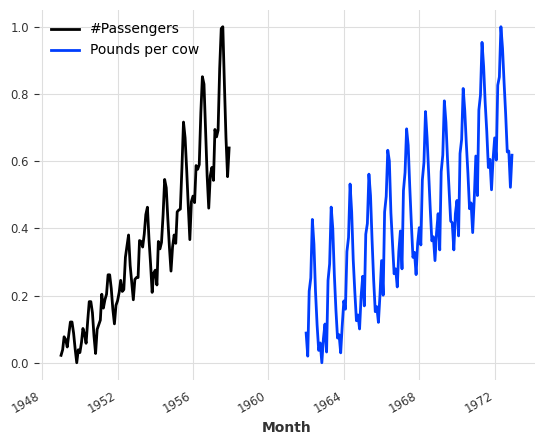

In [ ]:
# Scale the series

from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
train_air_scaled, train_milk_scaled = scaler.fit_transform([train_air, train_milk])

train_air_scaled.plot()
train_milk_scaled.plot()

### NBEATS

In [ ]:
# Using NBEATS

from darts.models import NBEATSModel

model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit([train_air_scaled, train_milk_scaled], epochs=50, verbose=True);

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Month'>

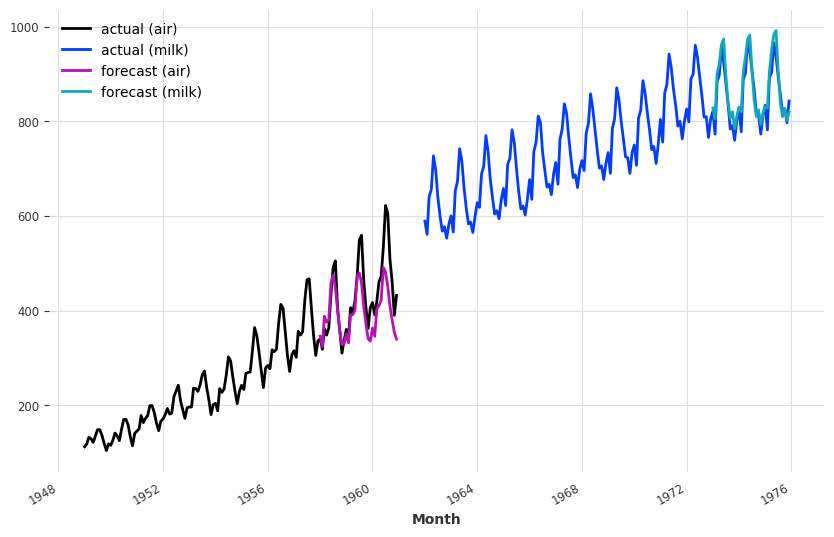

In [ ]:
pred_air = model.predict(series=train_air_scaled, n=36)
pred_milk = model.predict(series=train_milk_scaled, n=36)

# scale back:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")

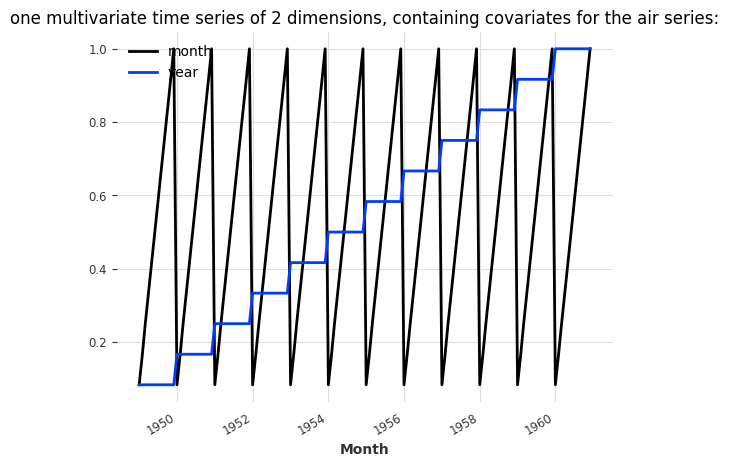

In [ ]:
# Include Covariates

from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

air_covs = concatenate(
    [
        dt_attr(series_air.time_index, "month", dtype=np.float32) / 12,
        (dt_attr(series_air.time_index, "year", dtype=np.float32) - 1948) / 12,
    ],
    axis="component",
)

milk_covs = concatenate(
    [
        dt_attr(series_milk.time_index, "month", dtype=np.float32) / 12,
        (dt_attr(series_milk.time_index, "year", dtype=np.float32) - 1962) / 13,
    ],
    axis="component",
)

air_covs.plot()
plt.title(
    "one multivariate time series of 2 dimensions, containing covariates for the air series:"
);

In [ ]:
# View datasets
display(milk_covs.head())
display(air_covs.head())

<TimeSeries (DataArray) (Month: 5, component: 2, sample: 1)>
array([[[0.08333334],
        [0.        ]],

       [[0.16666667],
        [0.        ]],

       [[0.25      ],
        [0.        ]],

       [[0.33333334],
        [0.        ]],

       [[0.41666666],
        [0.        ]]], dtype=float32)
Coordinates:
  * Month      (Month) datetime64[ns] 1962-01-01 1962-02-01 ... 1962-05-01
  * component  (component) object 'month' 'year'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<TimeSeries (DataArray) (Month: 5, component: 2, sample: 1)>
array([[[0.08333334],
        [0.08333334]],

       [[0.16666667],
        [0.08333334]],

       [[0.25      ],
        [0.08333334]],

       [[0.33333334],
        [0.08333334]],

       [[0.41666666],
        [0.08333334]]], dtype=float32)
Coordinates:
  * Month      (Month) datetime64[ns] 1949-01-01 1949-02-01 ... 1949-05-01
  * component  (component) object 'month' 'year'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
# Use covariates within the model
model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit(
    [train_air_scaled, train_milk_scaled],
    past_covariates=[air_covs, milk_covs],
    epochs=50,
    verbose=True,
);

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.6 M 
---------------------------------------------------
6.6 M     Trainable params
1.7 K     Non-trainable params
6.6 M     Total params
26.314    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Month'>

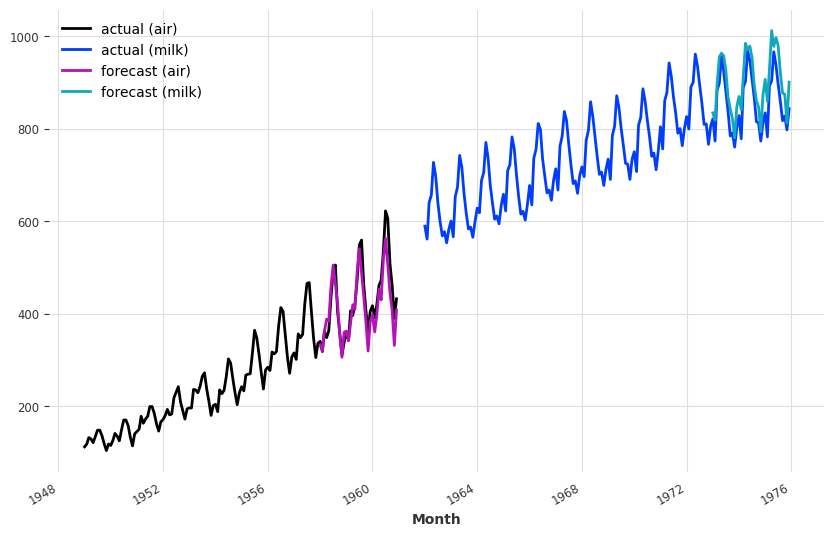

In [ ]:
pred_air = model.predict(series=train_air_scaled, past_covariates=air_covs, n=36)
pred_milk = model.predict(series=train_milk_scaled, past_covariates=milk_covs, n=36)

# scale back:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")

### Regression model wrapper

In [ ]:
# Wrapper around sklearn (or similar) models
from darts.models import RegressionModel
from sklearn.linear_model import BayesianRidge

model = RegressionModel(lags=72, lags_future_covariates=[-6, 0], model=BayesianRidge())

model.fit(
    [train_air_scaled, train_milk_scaled], future_covariates=[air_covs, milk_covs]
);

<Axes: xlabel='Month'>

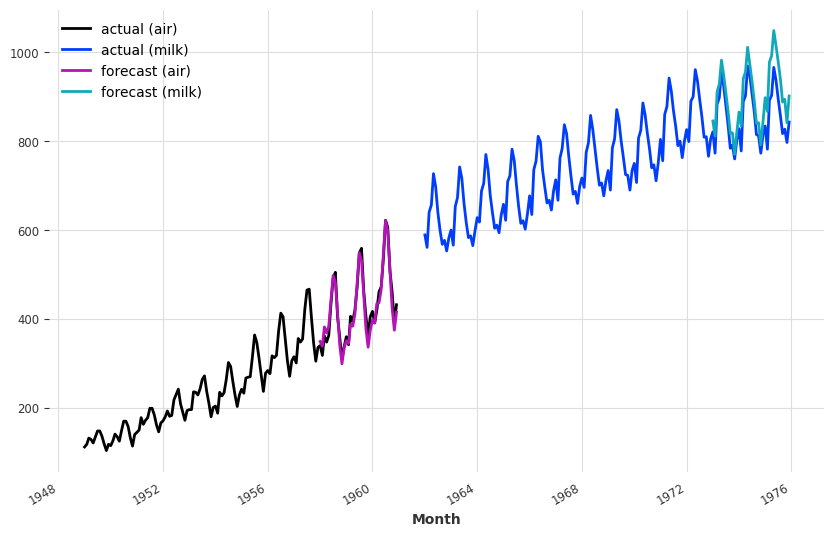

In [ ]:
pred_air, pred_milk = model.predict(
    series=[train_air_scaled, train_milk_scaled],
    future_covariates=[air_covs, milk_covs],
    n=36,
)

# scale back:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")

In [ ]:
mape([series_air, series_milk], [pred_air, pred_milk])

[3.417101874947548, 5.283059179782867]

In [ ]:
mape([series_air, series_milk], [pred_air, pred_milk], inter_reduction=np.mean)

4.350080527365208

100%|██████████| 57/57 [00:02<00:00, 25.92it/s]


MAPE = 3.66


<Axes: xlabel='time'>

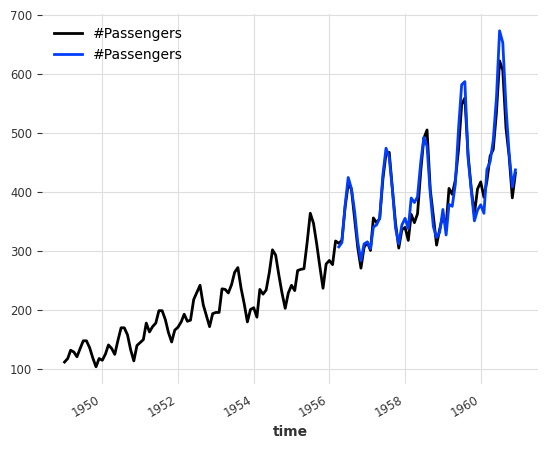

In [ ]:
# Backtest
bayes_ridge_model = RegressionModel(
    lags=72, lags_future_covariates=[0], model=BayesianRidge()
)

backtest = bayes_ridge_model.historical_forecasts(
    series_air, future_covariates=air_covs, start=0.6, forecast_horizon=3, verbose=True
)

print("MAPE = %.2f" % (mape(backtest, series_air)))
series_air.plot()
backtest.plot()

In [ ]:
def pipeline_model(
    series_target_1,
    series_target_2,
    series_sc_target_1,
    series_sc_target_2,
    series_name_1,
    series_name_2,
    series_covs_1,
    series_cov_2,
    scaler,
    reg_model
    ):

  # Train model
  model = RegressionModel(
      lags=72,
      lags_future_covariates=[-6, 0],
      model=reg_model()
      )
  model.fit(
      [series_sc_target_1, series_sc_target_2], future_covariates=[series_covs_1, series_cov_2]
  )

  # Get predictions
  pred_series_1, pred_series_2 = model.predict(
      series=[series_sc_target_1, series_sc_target_2],
      future_covariates=[series_covs_1, series_cov_2],
      n=36,
  )

  # Scale back
  pred_series_1, pred_series_2 = scaler.inverse_transform([pred_series_1, pred_series_2])

  plt.figure(figsize=(10, 6))
  series_target_1.plot(label=f"actual ({series_name_1})")
  series_target_2.plot(label=f"actual ({series_name_2})")
  pred_series_1.plot(label=f"forecast ({series_name_1})")
  pred_series_2.plot(label=f"forecast ({series_name_2})")

  print("MAPE:", mape([series_target_1, series_target_2], [pred_series_1, pred_series_2]))

  # Backtest - series 1
  model = RegressionModel(
      lags=72,
      lags_future_covariates=[0],
      model=reg_model()
  )

  backtest = model.historical_forecasts(
      series_target_1,
      future_covariates=series_covs_1,
      start=0.6,
      forecast_horizon=3,
      verbose=True
  )

  print("MAPE = %.2f" % (mape(backtest, series_target_1)))
  series_target_1.plot()
  backtest.plot()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2354
[LightGBM] [Info] Number of data points in the train set: 96, number of used features: 76
[LightGBM] [Info] Start training from score 0.603419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

MAPE: [11.110402861189247, 5.956870767152427]


  4%|▎         | 2/57 [00:00<00:03, 14.75it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 13, number of used features: 0
[LightGBM] [Info] Start training from score 284.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the sp

  7%|▋         | 4/57 [00:00<00:03, 14.57it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 16, number of used features: 0
[LightGBM] [Info] Start training from score 287.437500
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the sp

 11%|█         | 6/57 [00:00<00:03, 14.42it/s]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


 14%|█▍        | 8/57 [00:00<00:03, 14.65it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 19, number of used features: 0
[LightGBM] [Info] Start training from score 300.210526
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the sp

 21%|██        | 12/57 [00:00<00:02, 15.01it/s]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

 28%|██▊       | 16/57 [00:01<00:04,  9.21it/s]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

 32%|███▏      | 18/57 [00:01<00:03, 10.45it/s]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

 39%|███▊      | 22/57 [00:01<00:02, 12.43it/s]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

 42%|████▏     | 24/57 [00:01<00:02, 12.82it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 36, number of used features: 0
[LightGBM] [Info] Start training from score 326.888889
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the sp

 49%|████▉     | 28/57 [00:02<00:02, 13.50it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 39, number of used features: 0
[LightGBM] [Info] Start training from score 327.897436
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the sp

 53%|█████▎    | 30/57 [00:02<00:02, 13.14it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1009
[LightGBM] [Info] Number of data points in the train set: 42, number of used features: 69
[LightGBM] [Info] Start training from score 331.761905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

 60%|█████▉    | 34/57 [00:02<00:01, 13.29it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 secon

 63%|██████▎   | 36/57 [00:02<00:01, 13.35it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 70%|███████   | 40/57 [00:03<00:01, 13.44it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 74%|███████▎  | 42/57 [00:03<00:01, 13.14it/s]


[LightGBM] [Info] Total Bins 1315
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 74
[LightGBM] [Info] Start training from score 344.603774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

 77%|███████▋  | 44/57 [00:03<00:01, 12.88it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 84%|████████▍ | 48/57 [00:03<00:00, 12.83it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 88%|████████▊ | 50/57 [00:03<00:00, 12.68it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 61, number of used features: 74
[LightGBM] [Info] Start training from score 358.967213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

 91%|█████████ | 52/57 [00:04<00:00, 12.28it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 95%|█████████▍| 54/57 [00:04<00:00, 12.03it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1614
[LightGBM] [Info] Number of data points in the train set: 66, number of used features: 74
[LightGBM] [Info] Start training from score 366.287879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

100%|██████████| 57/57 [00:04<00:00, 12.45it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

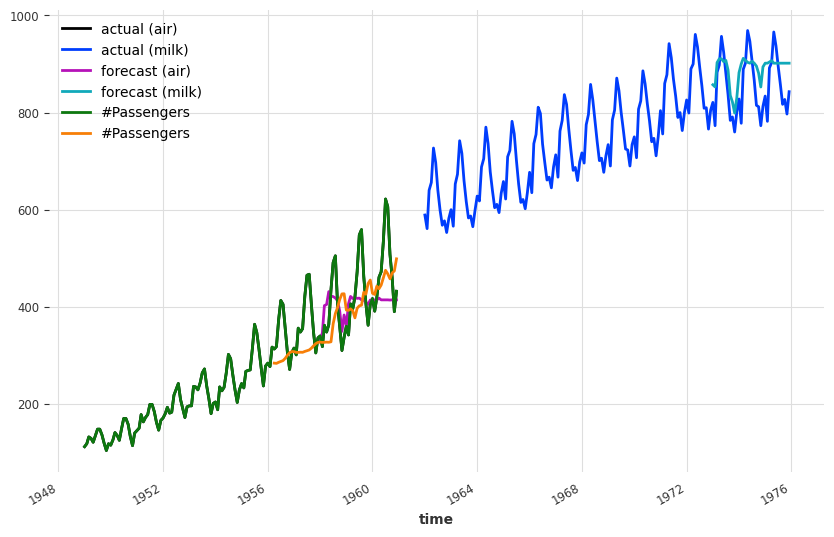

In [ ]:
# Use LightGBM
from lightgbm import LGBMRegressor

pipeline_model(
    series_target_1=series_air,
    series_target_2=series_milk,
    series_sc_target_1=train_air_scaled,
    series_sc_target_2=train_milk_scaled,
    series_name_1="air",
    series_name_2="milk",
    series_covs_1=air_covs,
    series_cov_2=milk_covs,
    scaler=scaler,
    reg_model=LGBMRegressor
    )

MAPE: [8.038248866796494, 6.649124622344971]


100%|██████████| 57/57 [00:00<00:00, 60.55it/s]


MAPE = 4.68


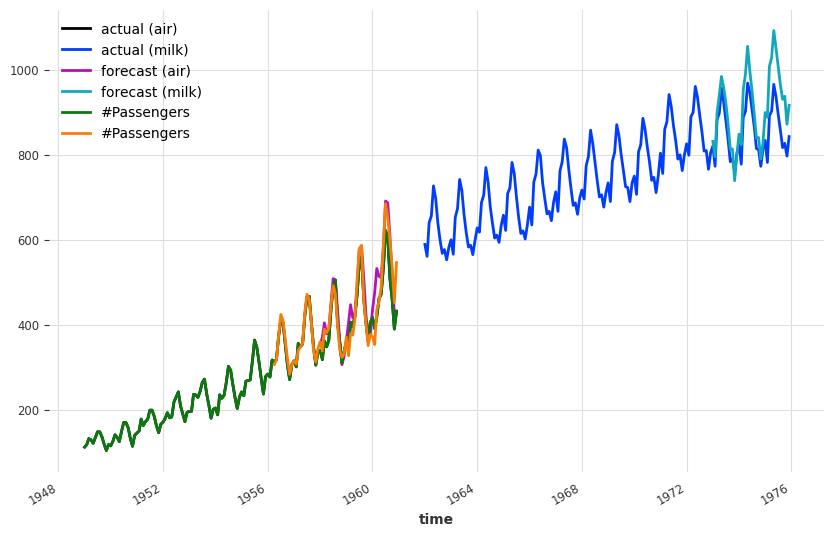

In [ ]:
# Use Linear Regression
from sklearn.linear_model import LinearRegression

pipeline_model(
    series_target_1=series_air,
    series_target_2=series_milk,
    series_sc_target_1=train_air_scaled,
    series_sc_target_2=train_milk_scaled,
    series_name_1="air",
    series_name_2="milk",
    series_covs_1=air_covs,
    series_cov_2=milk_covs,
    scaler=scaler,
    reg_model=LinearRegression
    )

### Probabilistic forecasts

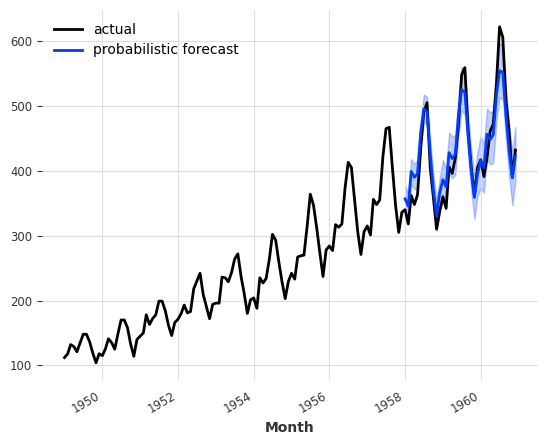

In [ ]:
model_es = ExponentialSmoothing()
model_es.fit(train)
probabilistic_forecast = model_es.predict(len(val), num_samples=500)

series.plot(label="actual")
probabilistic_forecast.plot(label="probabilistic forecast")
plt.legend()
plt.show()

In [ ]:
probabilistic_forecast.head(2)

<TimeSeries (DataArray) (Month: 2, component: 1, sample: 500)>
array([[[377.55991095, 361.92076704, 368.5550806 , 383.02762069,
         378.74676148, 346.12636688, 368.2265695 , 355.59681067,
         356.14879056, 362.04049244, 358.98403244, 374.00782273,
         366.05881415, 358.72754275, 362.42192346, 361.15843912,
         374.46425444, 354.97989928, 360.92215263, 347.53883853,
         328.05841938, 364.82708952, 367.24443581, 348.82229543,
         383.35856107, 340.65582558, 357.85704397, 355.18600343,
         374.90801075, 374.18079835, 359.10906181, 361.66856429,
         347.15253106, 334.61949132, 353.34300763, 359.12513265,
         371.43951704, 371.11947666, 352.89105818, 353.86598915,
         345.30908901, 341.04967492, 337.767355  , 379.70097631,
         351.48841077, 352.30916065, 342.96713755, 366.24746873,
         338.8265452 , 354.89295986, 347.06445878, 361.76878151,
         351.47519037, 343.79459874, 357.00920022, 362.24383263,
         358.09507427, 360.80065553, 350.05887954, 353.17297027,
         349.62156497, 353.20952562, 348.0083867 , 337.53788209,
         359.36681468, 352.72531959, 338.63963504, 362.63885899,
         346.92878906, 357.92798599, 365.69249106, 358.81133894,
         370.39732421, 343.1731858 , 361.9458149 , 349.47995743,
         347.34733132, 350.69495578, 353.75992626, 357.97637413,
...
         333.59997538, 362.12553678, 354.9939556 , 348.53017587,
         345.96379434, 372.91755092, 345.3605941 , 334.97036461,
         348.36339958, 363.46678363, 362.74208847, 338.78329555,
         351.85290829, 330.81401565, 339.45209931, 337.08968401,
         336.63639739, 365.11722791, 339.03607457, 339.94939994,
         348.87936505, 357.369747  , 351.08993934, 378.01875982,
         347.48097747, 348.45594945, 350.29488501, 359.50307727,
         349.38729864, 344.17017765, 331.92494341, 350.98033673,
         363.21968679, 341.91658648, 352.85926793, 354.45075811,
         354.37430799, 330.26587574, 373.30082037, 331.00720419,
         340.14130631, 353.76384728, 347.96051384, 355.85836465,
         338.68658859, 351.89538844, 343.20010408, 361.53484869,
         347.1598965 , 355.6779555 , 332.48123681, 355.37959102,
         347.61457816, 359.70920942, 373.91166735, 345.16034677,
         344.95225231, 333.3766526 , 347.41719347, 342.8650832 ,
         352.15932333, 347.12091756, 339.06225188, 356.80785034,
         337.54488853, 343.15462522, 345.51446819, 355.7157671 ,
         361.57296586, 342.9783843 , 347.91743018, 346.8646258 ,
         339.81559437, 352.3114557 , 356.88385763, 350.34191744,
         341.65265484, 345.42240823, 329.73537808, 341.49010194]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1958-01-01 1958-02-01
  * component  (component) object '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='Month'>

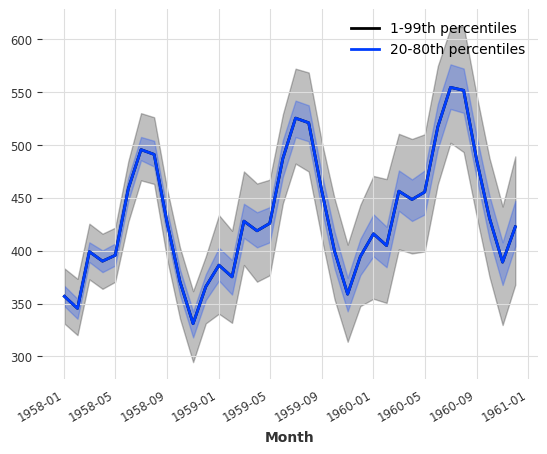

In [ ]:
probabilistic_forecast.plot(low_quantile=0.01, high_quantile=0.99, label="1-99th percentiles")
probabilistic_forecast.plot(low_quantile=0.2, high_quantile=0.8, label="20-80th percentiles")

In [ ]:
from darts.metrics import rho_risk

print("MAPE of median forecast: %.2f" % mape(series_air, probabilistic_forecast))
for rho in [0.05, 0.1, 0.5, 0.9, 0.95]:
    rr = rho_risk(series_air, probabilistic_forecast, rho=rho)
    print("rho-risk at quantile %.2f: %.2f" % (rho, rr))

MAPE of median forecast: 5.11
rho-risk at quantile 0.05: 0.00
rho-risk at quantile 0.10: 0.01
rho-risk at quantile 0.50: 0.01
rho-risk at quantile 0.90: 0.01
rho-risk at quantile 0.95: 0.01


## 2. Multivariate forecasting

In [ ]:
from darts.datasets import ElectricityDataset
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)
from darts.metrics import mape, smape, mae

In [ ]:
# Load dataset
multi_serie_elec = ElectricityDataset().load()

In [ ]:
multi_serie_elec.head(1)

<TimeSeries (DataArray) (Unnamed: 0: 1, component: 370, sample: 1)>
array([[[    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
...
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ],
        [    0.        ]]])
Coordinates:
  * Unnamed: 0  (Unnamed: 0) datetime64[ns] 2011-01-01T00:15:00
  * component   (component) object 'MT_001' 'MT_002' ... 'MT_369' 'MT_370'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

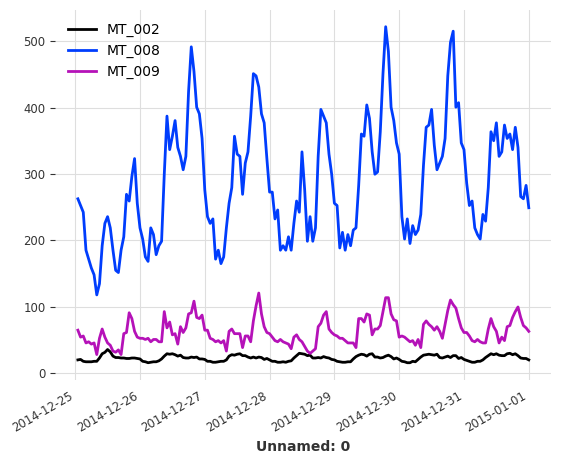

In [ ]:
# retaining only three components in different ranges
retained_components = ["MT_002", "MT_008", "MT_009"]
multi_serie_elec = multi_serie_elec[retained_components]
# resampling the multivariate time serie
multi_serie_elec = multi_serie_elec.resample(freq="1H")
# keep the values for the last 5 days
multi_serie_elec = multi_serie_elec[-168:]

multi_serie_elec.plot()
plt.show()

In [ ]:
multi_serie_elec.head(2)

<TimeSeries (DataArray) (Unnamed: 0: 2, component: 3, sample: 1)>
array([[[ 19.91465149],
        [262.62626263],
        [ 64.68531469]],

       [[ 20.62588905],
        [252.52525253],
        [ 54.1958042 ]]])
Coordinates:
  * Unnamed: 0  (Unnamed: 0) datetime64[ns] 2014-12-25T01:00:00 2014-12-25T02...
  * component   (component) object 'MT_002' 'MT_008' 'MT_009'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
# split in train/validation sets
training_set, validation_set = multi_serie_elec[:-24], multi_serie_elec[-24:]

# define a scaler, by default, normalize each component between 0 and 1
scaler_dataset = Scaler()
# scaler is fit on training set only to avoid leakage
training_scaled = scaler_dataset.fit_transform(training_set)
validation_scaled = scaler_dataset.transform(validation_set)


def fit_and_pred(model, training, validation):
    model.fit(training)
    forecast = model.predict(len(validation))
    return forecast

In [ ]:
# training and prediction with the VARIMA model
model_VARIMA = VARIMA(p=12, d=0, q=0, trend="n")
forecast_VARIMA = fit_and_pred(model_VARIMA, training_scaled, validation_scaled)
print("MAE (VARIMA) = {:.2f}".format(mae(validation_scaled, forecast_VARIMA)))
print("MAPE (VARIMA) = {:.2f}".format(mape(validation_scaled, forecast_VARIMA)))
print("sMAPE (VARIMA) = {:.2f}".format(smape(validation_scaled, forecast_VARIMA)))

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE (VARIMA) = 0.11
MAPE (VARIMA) = 47.94
sMAPE (VARIMA) = 32.16


<Axes: xlabel='Unnamed: 0'>

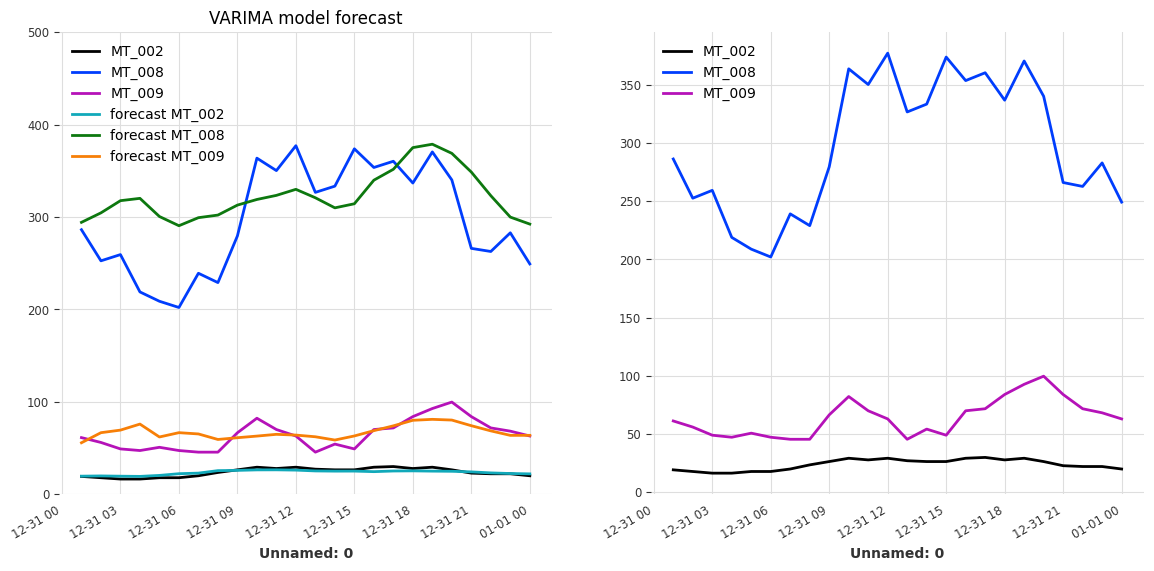

In [ ]:
# Plot results
forecast_VARIMA = scaler_dataset.inverse_transform(forecast_VARIMA)
labels = [f"forecast {component}" for component in retained_components]
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
validation_set.plot(ax=axs[0])
forecast_VARIMA.plot(label=labels, ax=axs[0])
axs[0].set_ylim(0, 500)
axs[0].set_title("VARIMA model forecast")
axs[0].legend(loc="upper left")
validation_set.plot(ax=axs[1])

# Example - Stores

Examples based on https://www.kaggle.com/code/ferdinandberr/darts-forecasting-deep-learning-global-models

## 1. Setup

In [ ]:
!pip install darts==0.27.2
!pip install lightgbm
!pip install prophet

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [47]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from sklearn import preprocessing
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
#from darts.metrics import mape, smape, rmse, rmsle
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import (
    Scaler,
    StaticCovariatesTransformer,
    MissingValuesFiller,
    InvertibleMapper
)
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    NaiveMovingAverage,
    ExponentialSmoothing,
    Prophet,
    AutoARIMA,
    LinearRegressionModel,
    NBEATSModel,
    RNNModel,
    TCNModel,
    TransformerModel,
    BlockRNNModel,
    VARIMA,
    StatsForecastAutoARIMA,
    RegressionEnsembleModel
)
from darts.utils.statistics import plot_acf, check_seasonality
from darts import concatenate
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error
from lightgbm import LGBMRegressor
from darts.models import RegressionModel
from sklearn.linear_model import BayesianRidge
from prophet import Prophet as fb_Prophet
from darts.utils.timeseries_generation import datetime_attribute_timeseries

In [ ]:
from IPython.display import display
pd.options.display.max_columns = None

### General functions

In [ ]:
def smape(A, F):
    tmp = 2 * np.abs(F - A) / (np.abs(A) + np.abs(F))
    len_ = np.count_nonzero(~np.isnan(tmp))
    if len_ == 0 and np.nansum(tmp) == 0: # Deals with a special case
        return 100
    return 100 / len_ * np.nansum(tmp)

In [ ]:
# Time Related Features
def create_date_features(df):
  """
  Reference: https://www.kaggle.com/code/ekrembayar/store-sales-ts-forecasting-a-comprehensive-guide#11.-Exponential-Moving-Average
  """
  df['date'] = pd.to_datetime(df['date'])

  df['month'] = df.date.dt.month.astype("int8")
  df['day_of_month'] = df.date.dt.day.astype("int8")
  df['day_of_year'] = df.date.dt.dayofyear.astype("int16")
  df['week_of_month'] = (df.date.apply(lambda d: (d.day-1) // 7 + 1)).astype("int8")
  df['week_of_year'] = (df.date.dt.weekofyear).astype("int8")
  df['day_of_week'] = (df.date.dt.dayofweek + 1).astype("int8")
  df['year'] = df.date.dt.year.astype("int32")
  df["is_wknd"] = (df.date.dt.weekday // 4).astype("int8")
  df["quarter"] = df.date.dt.quarter.astype("int8")
  df['is_month_start'] = df.date.dt.is_month_start.astype("int8")
  df['is_month_end'] = df.date.dt.is_month_end.astype("int8")
  df['is_quarter_start'] = df.date.dt.is_quarter_start.astype("int8")
  df['is_quarter_end'] = df.date.dt.is_quarter_end.astype("int8")
  df['is_year_start'] = df.date.dt.is_year_start.astype("int8")
  df['is_year_end'] = df.date.dt.is_year_end.astype("int8")
  # 0: Winter - 1: Spring - 2: Summer - 3: Fall
  df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
  df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
  df["season"] = pd.Series(np.where(df.month.isin([9, 10, 11]), 3, df["season"])).astype("int8")

  df['date'] = pd.to_datetime(df['date']).dt.date

  return df

In [ ]:
def pipeline_darts_univariate(
    model:object,
    train_darts:object,
    val_darts:object,
    list_dates_val:list,
    train_pipeline_univ:object
    )->dict:
  """
  Function for univariate forecasting with DARTS
  """
  # Train model
  model.fit(train_darts)

  # Get predictions
  predictions_univariate = model.predict(len(val_darts))
  predictions_univariate = train_pipeline_univ.inverse_transform(predictions_univariate, partial=True)
  val_darts = train_pipeline_univ.inverse_transform(val_darts, partial=True)

  # Evaluate
  df_forecast = pd.DataFrame(
      {
          'date': list_dates_val,
          'y_test': list([x[0] for x in val_darts.values()]),
          'y_pred': list([x[0] for x in predictions_univariate.values()])
      }
  )
  mape_metric = np.round(
      mean_absolute_percentage_error(
          df_forecast['y_test'].values,
          df_forecast['y_pred'].values
          ), 3)
  mae_metric = np.round(
      mean_absolute_error(
          df_forecast['y_test'].values,
          df_forecast['y_pred'].values
          ), 3)
  smape_metric = smape(
      df_forecast['y_test'].values,
      df_forecast['y_pred'].values
  )
  r2_metric = np.round(
      r2_score(df_forecast['y_test'].values, df_forecast['y_pred'].values), 3
      )
  print(f"MAPE: {mape_metric}")
  print(f"MAE: {mae_metric}")
  print(f"SMAPE: {smape_metric}")
  print(f"R2: {r2_metric}")

  # Plot results
  plt.figure(figsize=(15, 5))
  plt.xlabel('Dates')

  ax1 = df_forecast.y_test.plot(color='blue', grid=True, label='y_test')
  ax2 = df_forecast.y_pred.plot(color='red', grid=True, secondary_y=True, label='y_pred')

  h1, l1 = ax1.get_legend_handles_labels()
  h2, l2 = ax2.get_legend_handles_labels()

  plt.show()

  dct_results = {
      'model_fit':model,
      'df_forecast':df_forecast
  }

  return dct_results

In [ ]:
def pipeline_darts_univariate_covariates(
    model:object,
    train_darts:object,
    val_darts:object,
    list_dates_val:list,
    train_pipeline_univ:object,
    past_covariates:object
    )->dict:
  """
  Function for univariate forecasting with DARTS
  """
  # Train model
  model.fit(
      train_darts,
      past_covariates=past_covariates
      )

  # Get predictions
  predictions_univariate = model.predict(len(val_darts))
  predictions_univariate = train_pipeline_univ.inverse_transform(predictions_univariate, partial=True)
  val_darts = train_pipeline_univ.inverse_transform(val_darts, partial=True)

  # Evaluate
  df_forecast = pd.DataFrame(
      {
          'date': list_dates_val,
          'y_test': list([x[0] for x in val_darts.values()]),
          'y_pred': list([x[0] for x in predictions_univariate.values()])
      }
  )
  mape_metric = np.round(
      mean_absolute_percentage_error(
          df_forecast['y_test'].values,
          df_forecast['y_pred'].values
          ), 3)
  mae_metric = np.round(
      mean_absolute_error(
          df_forecast['y_test'].values,
          df_forecast['y_pred'].values
          ), 3)
  smape_metric = smape(
      df_forecast['y_test'].values,
      df_forecast['y_pred'].values
  )
  r2_metric = np.round(
      r2_score(df_forecast['y_test'].values, df_forecast['y_pred'].values), 3
      )
  print(f"MAPE: {mape_metric}")
  print(f"MAE: {mae_metric}")
  print(f"SMAPE: {smape_metric}")
  print(f"R2: {r2_metric}")

  # Plot results
  plt.figure(figsize=(15, 5))
  plt.xlabel('Dates')

  ax1 = df_forecast.y_test.plot(color='blue', grid=True, label='y_test')
  ax2 = df_forecast.y_pred.plot(color='red', grid=True, secondary_y=True, label='y_pred')

  h1, l1 = ax1.get_legend_handles_labels()
  h2, l2 = ax2.get_legend_handles_labels()

  plt.show()

  dct_results = {
      'model_fit':model,
      'df_forecast':df_forecast
  }

  return dct_results

In [ ]:
def pipeline_darts_metrics(
    predictions_univariate:object,
    val_darts:object,
    list_dates_val:list
    )->dict:
  """
  Function for univariate forecasting with DARTS
  """

  # Evaluate
  df_forecast = pd.DataFrame(
      {
          'date': list_dates_val,
          'y_test': list([x[0] for x in val_darts.values()]),
          'y_pred': list([x[0] for x in predictions_univariate.values()])
      }
  )
  mape_metric = np.round(
      mean_absolute_percentage_error(
          df_forecast['y_test'].values,
          df_forecast['y_pred'].values
          ), 3)
  mae_metric = np.round(
      mean_absolute_error(
          df_forecast['y_test'].values,
          df_forecast['y_pred'].values
          ), 3)
  smape_metric = smape(
      df_forecast['y_test'].values,
      df_forecast['y_pred'].values
  )
  r2_metric = np.round(
      r2_score(df_forecast['y_test'].values, df_forecast['y_pred'].values), 3
      )
  print(f"MAPE: {mape_metric}")
  print(f"MAE: {mae_metric}")
  print(f"SMAPE: {smape_metric}")
  print(f"R2: {r2_metric}")

  # Plot results
  plt.figure(figsize=(15, 5))
  plt.xlabel('Dates')

  ax1 = df_forecast.y_test.plot(color='blue', grid=True, label='y_test')
  ax2 = df_forecast.y_pred.plot(color='red', grid=True, secondary_y=True, label='y_pred')

  h1, l1 = ax1.get_legend_handles_labels()
  h2, l2 = ax2.get_legend_handles_labels()

  plt.show()

  dct_results = {
      'model_fit':model,
      'df_forecast':df_forecast
  }

  return dct_results

### Load data

In [ ]:
# Load data
f_path = "/content/gdrive/MyDrive/Colab Notebooks/Forecasting/store-sales-time-series-forecasting"

df_train = pd.read_csv(f_path + '/train.csv')
df_test = pd.read_csv(f_path + '/test.csv')
df_holidays_events = pd.read_csv(f_path + '/holidays_events.csv')
df_oil = pd.read_csv(f_path + '/oil.csv')
df_stores = pd.read_csv(f_path + '/stores.csv')
df_transactions = pd.read_csv(f_path + '/transactions.csv')
df_sample_submission = pd.read_csv(f_path + '/sample_submission.csv')

print(len(df_train))
df_train.head(10)

3000888


id        date  store_nbr        family  sales  onpromotion
0   0  2013-01-01          1    AUTOMOTIVE    0.0            0
1   1  2013-01-01          1     BABY CARE    0.0            0
2   2  2013-01-01          1        BEAUTY    0.0            0
3   3  2013-01-01          1     BEVERAGES    0.0            0
4   4  2013-01-01          1         BOOKS    0.0            0
5   5  2013-01-01          1  BREAD/BAKERY    0.0            0
6   6  2013-01-01          1   CELEBRATION    0.0            0
7   7  2013-01-01          1      CLEANING    0.0            0
8   8  2013-01-01          1         DAIRY    0.0            0
9   9  2013-01-01          1          DELI    0.0            0

### Simple EDA

In [ ]:
df_stores.head(5)

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [ ]:
df_transactions.head(5)

date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922

In [ ]:
df_holidays_events.head(5)

date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [ ]:
df_stores[df_stores['state']=='Cotopaxi']

store_nbr       city     state type  cluster
11         12  Latacunga  Cotopaxi    C       15
12         13  Latacunga  Cotopaxi    C       15

In [ ]:
df_oil.head(5)

date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20

### Prepare data

In [ ]:
# Prepare data
df_train = pd.merge(df_train, df_stores, on ='store_nbr')
df_train = df_train.sort_values(["store_nbr","family","date"])
df_train = df_train.astype(
    {"store_nbr":'str', "family":'str', "city":'str',
     "state":'str', "type":'str', "cluster":'str'}
    )
df_train = df_train.merge(
  df_holidays_events.rename(columns={'type':'type_holiday'}),
  left_on = ['date', 'state'],
  right_on = ['date', 'locale_name'],
  how = "left"
)
df_train = df_train.merge(
  df_oil,
  left_on = ['date'],
  right_on = ['date'],
  how = "left"
)
df_train['type_holiday'] = df_train['type_holiday'].fillna("Not Holiday")
df_train['locale'] = df_train['locale'].fillna("Not Holiday")
df_train['locale_name'] = df_train['locale_name'].fillna("Not Holiday")
df_train['description'] = df_train['description'].fillna("Not Holiday")
df_train['transferred'] = df_train['transferred'].fillna("False")

print(len(df_train), len(df_test))
df_train.head(10)

3000888 28512


id        date store_nbr      family  sales  onpromotion   city  \
0      0  2013-01-01         1  AUTOMOTIVE    0.0            0  Quito   
1   1782  2013-01-02         1  AUTOMOTIVE    2.0            0  Quito   
2   3564  2013-01-03         1  AUTOMOTIVE    3.0            0  Quito   
3   5346  2013-01-04         1  AUTOMOTIVE    3.0            0  Quito   
4   7128  2013-01-05         1  AUTOMOTIVE    5.0            0  Quito   
5   8910  2013-01-06         1  AUTOMOTIVE    2.0            0  Quito   
6  10692  2013-01-07         1  AUTOMOTIVE    0.0            0  Quito   
7  12474  2013-01-08         1  AUTOMOTIVE    2.0            0  Quito   
8  14256  2013-01-09         1  AUTOMOTIVE    2.0            0  Quito   
9  16038  2013-01-10         1  AUTOMOTIVE    2.0            0  Quito   

       state type cluster type_holiday       locale  locale_name  description  \
0  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday  Not Holiday   
1  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday  Not Holiday   
2  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday  Not Holiday   
3  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday  Not Holiday   
4  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday  Not Holiday   
5  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday  Not Holiday   
6  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday  Not Holiday   
7  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday  Not Holiday   
8  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday  Not Holiday   
9  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday  Not Holiday   

  transferred  dcoilwtico  
0       False         NaN  
1       False       93.14  
2       False       92.97  
3       False       93.12  
4       False         NaN  
5       False         NaN  
6       False       93.20  
7       False       93.21  
8       False       93.08  
9       False       93.81

In [ ]:
# Include time related features
df_train = create_date_features(df_train)
df_train['date'] = df_train['date'].astype(str)

<ipython-input-6-b68fc37dedbe>:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week_of_year'] = (df.date.dt.weekofyear).astype("int8")


In [ ]:
df_train.head(5)

id        date store_nbr      family  sales  onpromotion   city  \
0     0  2013-01-01         1  AUTOMOTIVE    0.0            0  Quito   
1  1782  2013-01-02         1  AUTOMOTIVE    2.0            0  Quito   
2  3564  2013-01-03         1  AUTOMOTIVE    3.0            0  Quito   
3  5346  2013-01-04         1  AUTOMOTIVE    3.0            0  Quito   
4  7128  2013-01-05         1  AUTOMOTIVE    5.0            0  Quito   

       state type cluster type_holiday       locale  locale_name  description  \
0  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday  Not Holiday   
1  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday  Not Holiday   
2  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday  Not Holiday   
3  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday  Not Holiday   
4  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday  Not Holiday   

  transferred  dcoilwtico  month  day_of_month  day_of_year  week_of_month  \
0       False         NaN      1             1            1              1   
1       False       93.14      1             2            2              1   
2       False       92.97      1             3            3              1   
3       False       93.12      1             4            4              1   
4       False         NaN      1             5            5              1   

   week_of_year  day_of_week  year  is_wknd  quarter  is_month_start  \
0             1            2  2013        0        1               1   
1             1            3  2013        0        1               0   
2             1            4  2013        0        1               0   
3             1            5  2013        1        1               0   
4             1            6  2013        1        1               0   

   is_month_end  is_quarter_start  is_quarter_end  is_year_start  is_year_end  \
0             0                 1               0              1            0   
1             0                 0               0              0            0   
2             0                 0               0              0            0   
3             0                 0               0              0            0   
4             0                 0               0              0            0   

   season  
0       0  
1       0  
2       0  
3       0  
4       0

In [ ]:
# Display dataframe
df_train = pd.get_dummies(df_train, columns=["type_holiday"])
df_train.head(10)

id        date store_nbr      family  sales  onpromotion   city  \
0      0  2013-01-01         1  AUTOMOTIVE    0.0            0  Quito   
1   1782  2013-01-02         1  AUTOMOTIVE    2.0            0  Quito   
2   3564  2013-01-03         1  AUTOMOTIVE    3.0            0  Quito   
3   5346  2013-01-04         1  AUTOMOTIVE    3.0            0  Quito   
4   7128  2013-01-05         1  AUTOMOTIVE    5.0            0  Quito   
5   8910  2013-01-06         1  AUTOMOTIVE    2.0            0  Quito   
6  10692  2013-01-07         1  AUTOMOTIVE    0.0            0  Quito   
7  12474  2013-01-08         1  AUTOMOTIVE    2.0            0  Quito   
8  14256  2013-01-09         1  AUTOMOTIVE    2.0            0  Quito   
9  16038  2013-01-10         1  AUTOMOTIVE    2.0            0  Quito   

       state type cluster       locale  locale_name  description transferred  \
0  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday       False   
1  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday       False   
2  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday       False   
3  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday       False   
4  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday       False   
5  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday       False   
6  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday       False   
7  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday       False   
8  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday       False   
9  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday       False   

   dcoilwtico  month  day_of_month  day_of_year  week_of_month  week_of_year  \
0         NaN      1             1            1              1             1   
1       93.14      1             2            2              1             1   
2       92.97      1             3            3              1             1   
3       93.12      1             4            4              1             1   
4         NaN      1             5            5              1             1   
5         NaN      1             6            6              1             1   
6       93.20      1             7            7              1             2   
7       93.21      1             8            8              2             2   
8       93.08      1             9            9              2             2   
9       93.81      1            10           10              2             2   

   day_of_week  year  is_wknd  quarter  is_month_start  is_month_end  \
0            2  2013        0        1               1             0   
1            3  2013        0        1               0             0   
2            4  2013        0        1               0             0   
3            5  2013        1        1               0             0   
4            6  2013        1        1               0             0   
5            7  2013        1        1               0             0   
6            1  2013        0        1               0             0   
7            2  2013        0        1               0             0   
8            3  2013        0        1               0             0   
9            4  2013        0        1               0             0   

   is_quarter_start  is_quarter_end  is_year_start  is_year_end  season  \
0                 1               0              1            0       0   
1                 0               0              0            0       0   
2                 0               0              0            0       0   
3                 0               0              0            0       0   
4                 0               0              0            0       0   
5                 0               0              0            0       0   
6                 0               0              0            0       0   
7                 0               0            

In [ ]:
# Sample filter for one family
if True:
  family_used = 'AUTOMOTIVE'
  df_train = df_train[df_train['family']==family_used]
  df_test = df_test[df_test['family']==family_used]
  print(len(df_train), len(df_test))
  df_train.head(10)

90936 864


In [ ]:
# Get val test
per_samples = 0.1
df_dates = df_train[['date']].drop_duplicates().copy()
n_samples_val = int(np.round(len(df_dates)*per_samples))
df_dates_train = df_dates[:len(df_dates)-n_samples_val].copy()
df_dates_val = df_dates[len(df_dates)-n_samples_val:].copy()

df_train_sp = df_train.merge(df_dates_train, how="inner")
df_val_sp = df_train.merge(df_dates_val, how="inner")

print(len(df_train_sp), df_train_sp['date'].min(), df_train_sp['date'].max())
print(len(df_val_sp), df_val_sp['date'].min(), df_val_sp['date'].max())

81864 2013-01-01 2017-02-28
9072 2017-03-01 2017-08-15


In [ ]:
# Transform data to Darts format
df_train_fc = TimeSeries.from_group_dataframe(
  df_train_sp,
  time_col="date",
  group_cols=["store_nbr","family"],  # individual time series are extracted by grouping `df` by `group_cols`
  static_cols=["city","state","type","cluster"], # also extract these additional columns as static covariates
  value_cols="sales", # target variable
  fill_missing_dates=True,
  freq='D'
)
df_val_fc = TimeSeries.from_group_dataframe(
  df_val_sp,
  time_col="date",
  group_cols=["store_nbr","family"],  # individual time series are extracted by grouping `df` by `group_cols`
  static_cols=["city","state","type","cluster"], # also extract these additional columns as static covariates
  value_cols="sales", # target variable
  fill_missing_dates=True,
  freq='D'
)

In [ ]:
df_train_fc[0]

<TimeSeries (DataArray) (date: 1520, component: 1, sample: 1)>
array([[[0.]],

       [[2.]],

       [[3.]],

       ...,

       [[1.]],

       [[3.]],

       [[2.]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-01 2013-01-02 ... 2017-02-28
  * component  (component) object 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates store_nbr      family   city      s...
    hierarchy:          None

In [ ]:
# Past Covariates
df_oil_train_fc = TimeSeries.from_group_dataframe(
  df_train_sp,
  time_col="date",
  group_cols=["store_nbr","family"],  # individual time series are extracted by grouping `df` by `group_cols`
  static_cols=["city","state","type","cluster"], # also extract these additional columns as static covariates
  value_cols="dcoilwtico", # covariate
  fill_missing_dates=True,
  freq='D'
)

df_oil_val_fc = TimeSeries.from_group_dataframe(
  df_val_sp,
  time_col="date",
  group_cols=["store_nbr","family"],  # individual time series are extracted by grouping `df` by `group_cols`
  static_cols=["city","state","type","cluster"], # also extract these additional columns as static covariates
  value_cols="dcoilwtico", # covariate
  fill_missing_dates=True,
  freq='D'
)

df_oil_train_fc[0]

<TimeSeries (DataArray) (date: 1520, component: 1, sample: 1)>
array([[[  nan]],

       [[93.14]],

       [[92.97]],

       ...,

       [[  nan]],

       [[54.04]],

       [[54.  ]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-01 2013-01-02 ... 2017-02-28
  * component  (component) object 'dcoilwtico'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates store_nbr      family   city      s...
    hierarchy:          None

In [ ]:
# Future Covariates
df_is_holiday_train_fc = TimeSeries.from_group_dataframe(
  df_train_sp,
  time_col="date",
  group_cols=["store_nbr","family"],  # individual time series are extracted by grouping `df` by `group_cols`
  static_cols=["city","state","type","cluster"], # also extract these additional columns as static covariates
  value_cols="type_holiday_Holiday", # covariate
  fill_missing_dates=True,
  freq='D'
)
df_is_holiday_val_fc = TimeSeries.from_group_dataframe(
  df_val_sp,
  time_col="date",
  group_cols=["store_nbr","family"],  # individual time series are extracted by grouping `df` by `group_cols`
  static_cols=["city","state","type","cluster"], # also extract these additional columns as static covariates
  value_cols="type_holiday_Holiday", # covariate
  fill_missing_dates=True,
  freq='D'
)
df_is_holiday_train_fc[0]

<TimeSeries (DataArray) (date: 1520, component: 1, sample: 1)>
array([[[0.]],

       [[0.]],

       [[0.]],

       ...,

       [[0.]],

       [[0.]],

       [[0.]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-01 2013-01-02 ... 2017-02-28
  * component  (component) object 'type_holiday_Holiday'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates    store_nbr      family   city    ...
    hierarchy:          None

In [ ]:
# Preprocessing
train_filler = MissingValuesFiller(
    verbose=False,
    n_jobs=-1,
    name="Fill NAs"
    )
static_cov_transformer = StaticCovariatesTransformer(
  verbose=False,
  transformer_cat = sklearn.preprocessing.OneHotEncoder(),
  name="Encoder"
)
train_scaler = Scaler(
    verbose=False,
    n_jobs=-1,
    name="Scaling"
    )

## 2. Univariate forecasting

In [44]:
## Forecasting - Univariate TS
# Choose TS
id_series = 0

# Preprocessing
train_pipeline_univ = Pipeline(
    [
      train_filler,
      static_cov_transformer,
      train_scaler
    ]
)

training_univariate = train_pipeline_univ.fit_transform(df_train_fc[id_series])
validation_univariate = train_pipeline_univ.transform(df_val_fc[id_series])
list_dates_val = list(df_dates_val['date'].values)

Nb datapoints: 3040


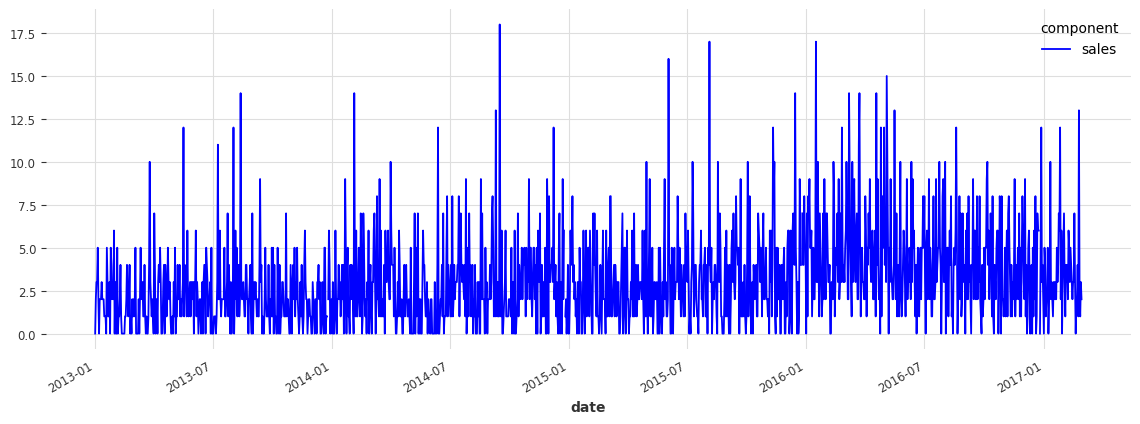

In [ ]:
# Plot TS
df_plot = pd.concat([
      df_train_fc[id_series].pd_dataframe(),
      df_train_fc[id_series].pd_dataframe(),
  ]
)
print("Nb datapoints:", len(df_plot))
df_plot.plot(figsize=(14,5), color="blue")
plt.show()

MAPE: 489775430116844.1
MAE: 2.221
SMAPE: 57.675989629956874
R2: -0.189


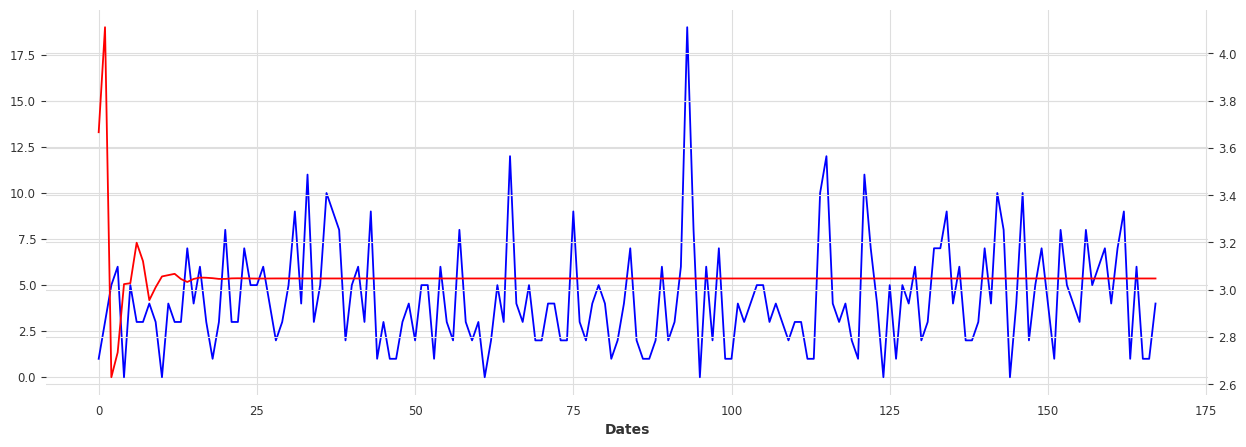

In [35]:
# Naive Moving Average
model = NaiveMovingAverage(input_chunk_length=6)
dct_results = pipeline_darts_univariate(
  model=model,
  train_darts=training_univariate,
  val_darts=validation_univariate,
  list_dates_val=list_dates_val,
  train_pipeline_univ=train_pipeline_univ
)

MAPE: 509335672143092.56
MAE: 3.327
SMAPE: 87.37031541443307
R2: -1.475


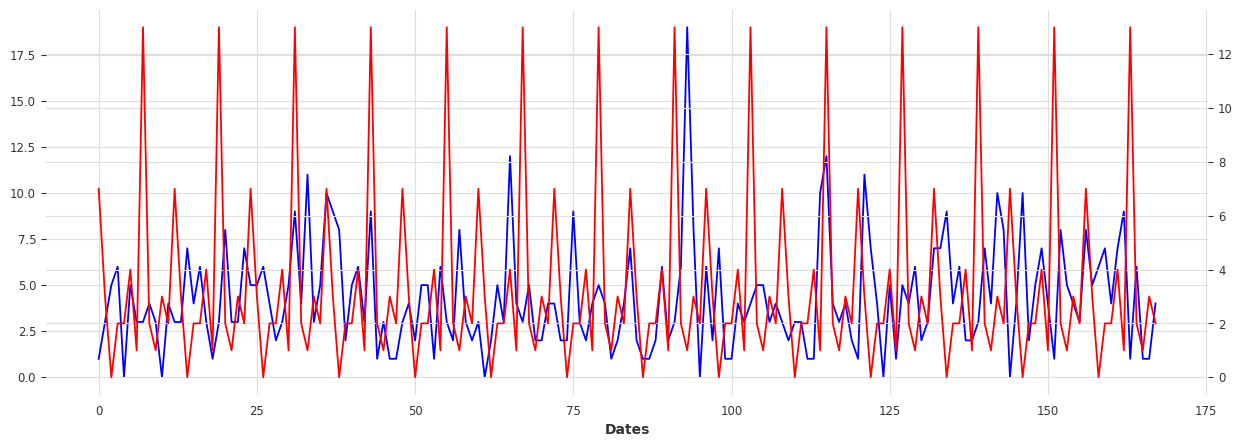

In [46]:
# Naive Moving Average
model = NaiveSeasonal(K=12)
dct_results = pipeline_darts_univariate(
  model=model,
  train_darts=training_univariate,
  val_darts=validation_univariate,
  list_dates_val=list_dates_val,
  train_pipeline_univ=train_pipeline_univ
)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbvidqvoo/7864axqs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbvidqvoo/dh7af3nq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70471', 'data', 'file=/tmp/tmpbvidqvoo/7864axqs.json', 'init=/tmp/tmpbvidqvoo/dh7af3nq.json', 'output', 'file=/tmp/tmpbvidqvoo/prophet_modelaxy12rii/prophet_model-20240217090924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:09:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:09:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAPE: 573513903768641.4
MAE: 2.113
SMAPE: 53.91475551498643
R2: 0.081


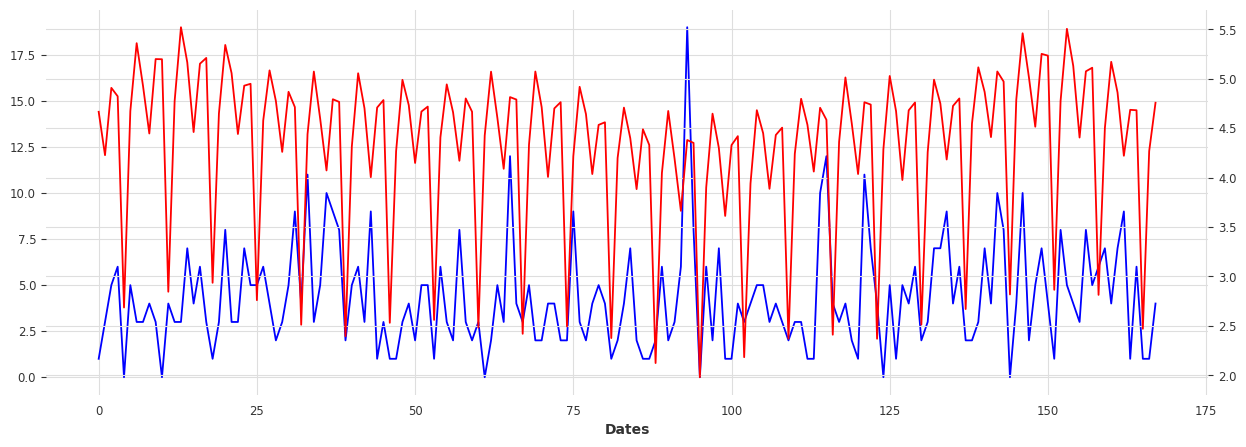

In [ ]:
# Prophet
model = Prophet(
  add_seasonalities={
    'name':"quarterly_seasonality",
    'seasonal_periods':4,
    'fourier_order':5
    }
)

dct_results = pipeline_darts_univariate(
  model=model,
  train_darts=training_univariate,
  val_darts=validation_univariate,
  list_dates_val=list_dates_val,
  train_pipeline_univ=train_pipeline_univ
)

There is seasonality of order 3.
There is seasonality of order 7.
There is seasonality of order 11.
There is seasonality of order 14.
There is seasonality of order 18.
There is seasonality of order 21.
MAPE: 375299968947542.1
MAE: 2.72
SMAPE: 71.88238119154184
R2: -0.63


<ipython-input-4-8de074af2f60>:2: RuntimeWarning: invalid value encountered in divide
  tmp = 2 * np.abs(F - A) / (np.abs(A) + np.abs(F))


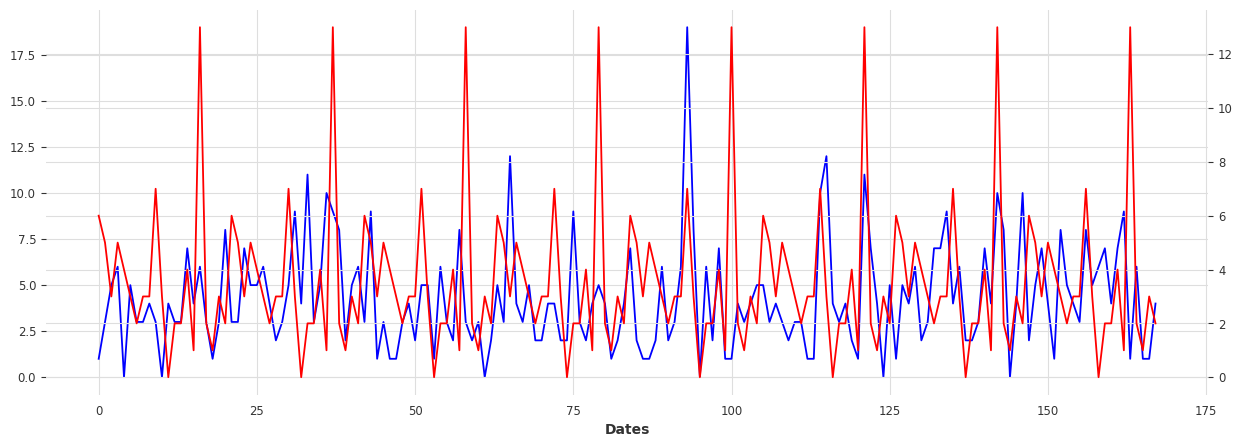

In [ ]:
# Naive Seasonal
list_k = []
for m in range(2, 25):
    is_seasonal, period = check_seasonality(training_univariate, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))
        list_k.append(period)
k_chosen = max(list_k)

# Fit model
model = NaiveSeasonal(K=k_chosen)

# Pipeline
dct_results = pipeline_darts_univariate(
  model=model,
  train_darts=training_univariate,
  val_darts=validation_univariate,
  list_dates_val=list_dates_val,
  train_pipeline_univ=train_pipeline_univ
)

MAPE: 583302828869718.6
MAE: 2.164
SMAPE: 55.527523586376624
R2: -0.051


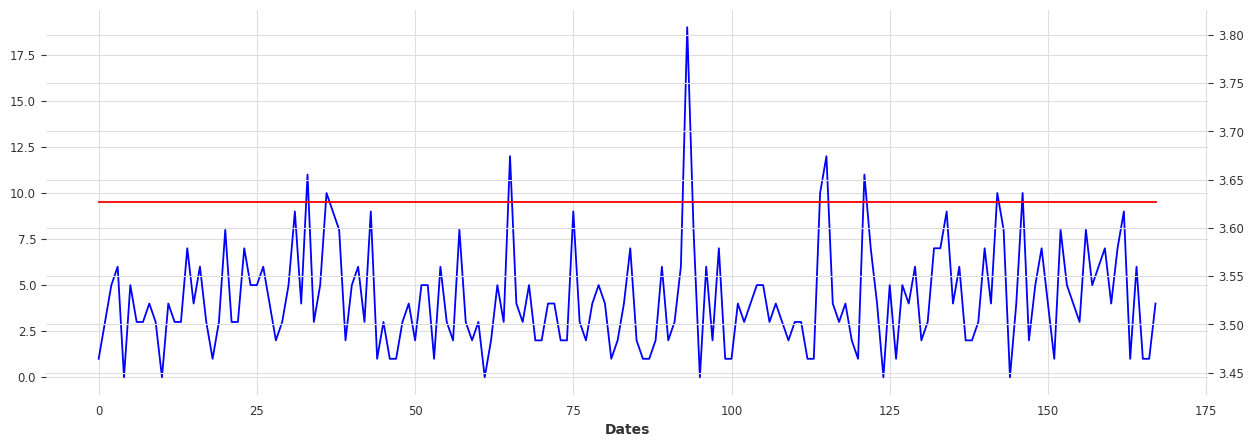

In [ ]:
# AutoArima
model = AutoARIMA(
  start_p=8,
  max_p=12,
  start_q=1
)

# Pipeline
dct_results = pipeline_darts_univariate(
  model=model,
  train_darts=training_univariate,
  val_darts=validation_univariate,
  list_dates_val=list_dates_val,
  train_pipeline_univ=train_pipeline_univ
)

MAPE: 586624468886210.2
MAE: 2.164
SMAPE: 55.514525834081375
R2: -0.054


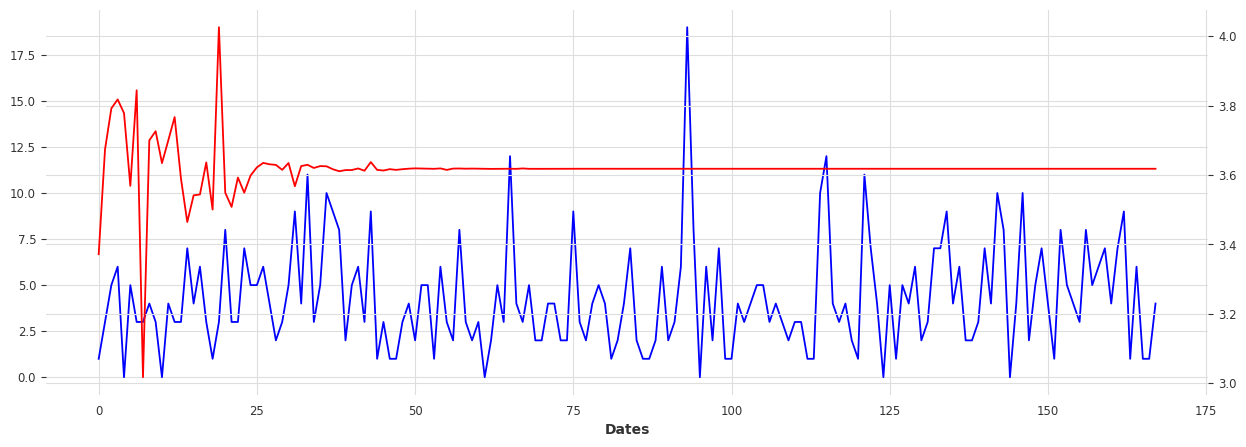

In [ ]:
# AutoArima (II)
model = StatsForecastAutoARIMA(
  season_length=12
)

# Pipeline
dct_results = pipeline_darts_univariate(
  model=model,
  train_darts=training_univariate,
  val_darts=validation_univariate,
  list_dates_val=list_dates_val,
  train_pipeline_univ=train_pipeline_univ
)

MAPE: 528150228975046.3
MAE: 2.2
SMAPE: 56.88578778437985
R2: -0.158


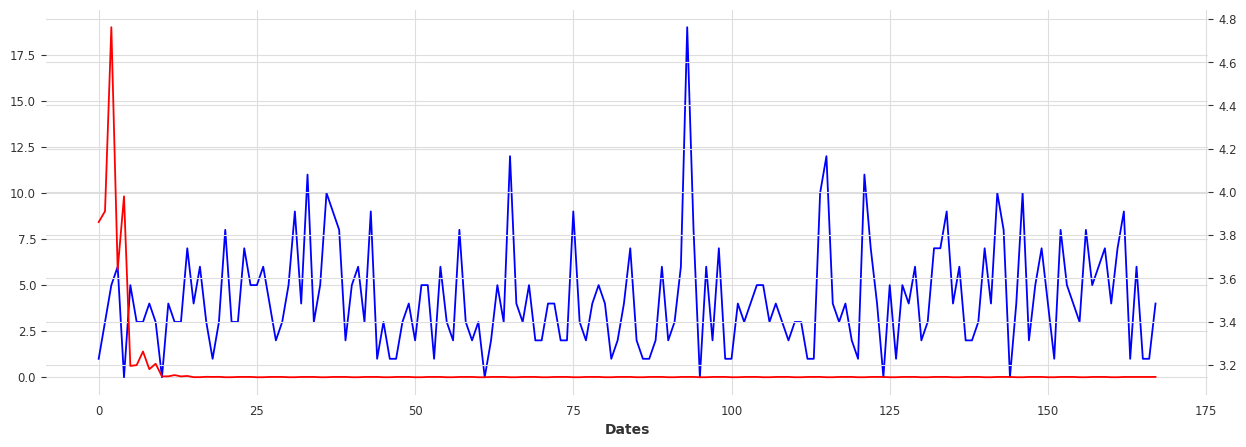

In [ ]:
# Linear Regression
model = LinearRegressionModel(
    lags=[-5],
    output_chunk_length=5
)

# Pipeline
dct_results = pipeline_darts_univariate(
  model=model,
  train_darts=training_univariate,
  val_darts=validation_univariate,
  list_dates_val=list_dates_val,
  train_pipeline_univ=train_pipeline_univ
)

MAPE: 477408735529180.06
MAE: 2.062
SMAPE: 53.38212204068021
R2: 0.053


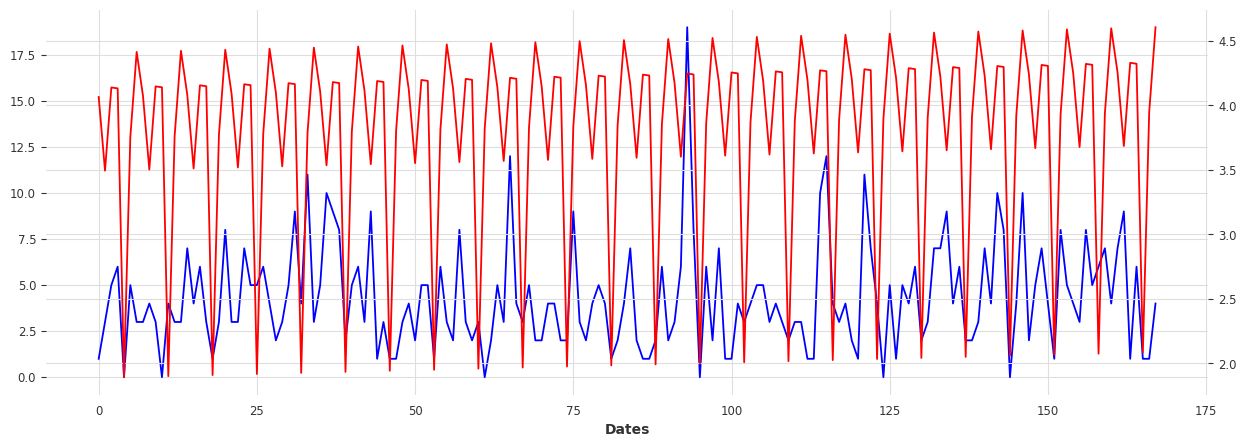

In [ ]:
# ExponentialSmoothing
model = ExponentialSmoothing()

# Pipeline
dct_results = pipeline_darts_univariate(
  model=model,
  train_darts=training_univariate,
  val_darts=validation_univariate,
  list_dates_val=list_dates_val,
  train_pipeline_univ=train_pipeline_univ
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.1 M 
---------------------------------------------------
6.1 M     Trainable params
1.3 K     Non-trainable params
6.1 M     Total params
24.249    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE: 718502169687983.8
MAE: 2.421
SMAPE: 59.52064667714171
R2: -0.238


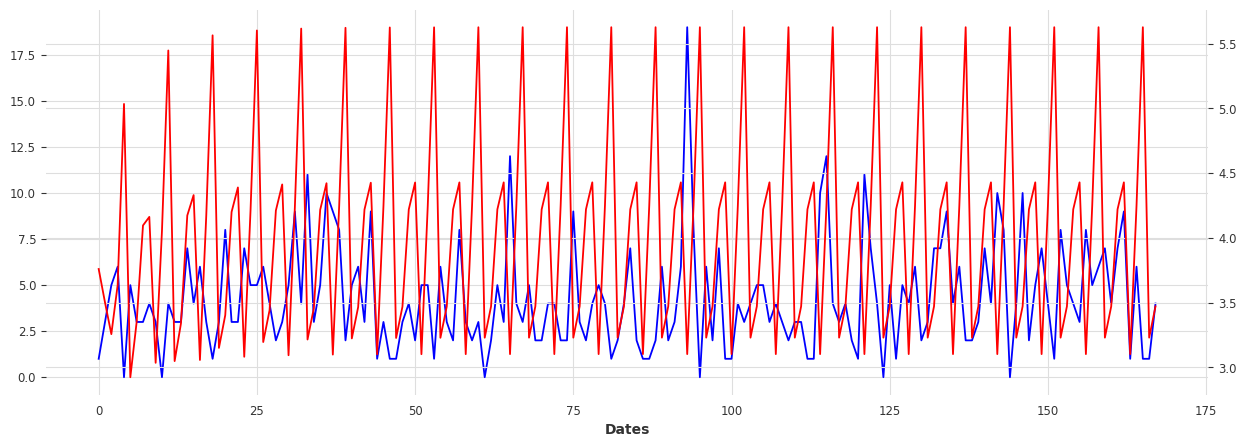

In [ ]:
# NBEATS
model = NBEATSModel(
    input_chunk_length=7,
    output_chunk_length=7,
    n_epochs=10,
    random_state=0
)

# Pipeline
dct_results = pipeline_darts_univariate(
  model=model,
  train_darts=training_univariate,
  val_darts=validation_univariate,
  list_dates_val=list_dates_val,
  train_pipeline_univ=train_pipeline_univ
)

MAPE: 496142619797740.75
MAE: 2.241
SMAPE: 58.34217911030256
R2: -0.169


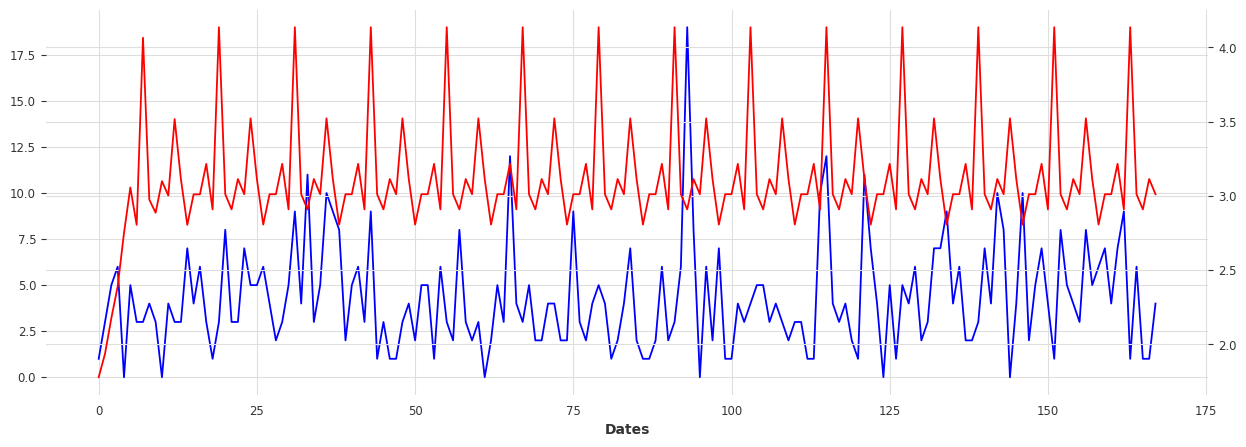

In [50]:
# Regression Ensemble
model = RegressionEnsembleModel(
    forecasting_models = [
        NaiveSeasonal(K=12),
        LinearRegressionModel(lags=4)
    ],
    regression_train_n_points=20
)

# Pipeline
dct_results = pipeline_darts_univariate(
  model=model,
  train_darts=training_univariate,
  val_darts=validation_univariate,
  list_dates_val=list_dates_val,
  train_pipeline_univ=train_pipeline_univ
)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgsl4gvj/z5393kfz.json


There is seasonality of order 3.
There is seasonality of order 7.
There is seasonality of order 11.
There is seasonality of order 14.
There is seasonality of order 18.
There is seasonality of order 21.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgsl4gvj/zpba_q81.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45251', 'data', 'file=/tmp/tmpqgsl4gvj/z5393kfz.json', 'init=/tmp/tmpqgsl4gvj/zpba_q81.json', 'output', 'file=/tmp/tmpqgsl4gvj/prophet_modelwjv18bi_/prophet_model-20240218192924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:29:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:29:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 1482, number of used features: 2
[LightGBM] [Info] Start training from score 0.174558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 1482, number of used features: 2
[LightGBM] [Info] Start training from score 0.174633
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 1482, number of used features: 2
[LightGBM] [Info] Start training from s

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.para

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 1482, number of used features: 2
[LightGBM] [Info] Start training from score 0.174783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 1482, number of used features: 2
[LightGBM] [Info] Start training from score 0.175008


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgsl4gvj/y982w8c3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgsl4gvj/aoluajav.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71763', 'data', 'file=/tmp/tmpqgsl4gvj/y982w8c3.json', 'init=/tmp/tmpqgsl4gvj/aoluajav.json', 'output', 'file=/tmp/tmpqgsl4gvj/prophet_model9daj0egb/prophet_model-20240218192925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:29:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:29:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed`

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 1502, number of used features: 2
[LightGBM] [Info] Start training from score 0.175007
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 1502, number of used features: 2
[LightGBM] [Info] Start training from score 0.175044


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.para

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 1502, number of used features: 2
[LightGBM] [Info] Start training from score 0.175044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 1502, number of used features: 2
[LightGBM] [Info] Start training from score 0.175118


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 1502, number of used features: 2
[LightGBM] [Info] Start training from score 0.175192
MAPE: 509048561528033.06
MAE: 2.144
SMAPE: 55.38201942573196
R2: -0.075


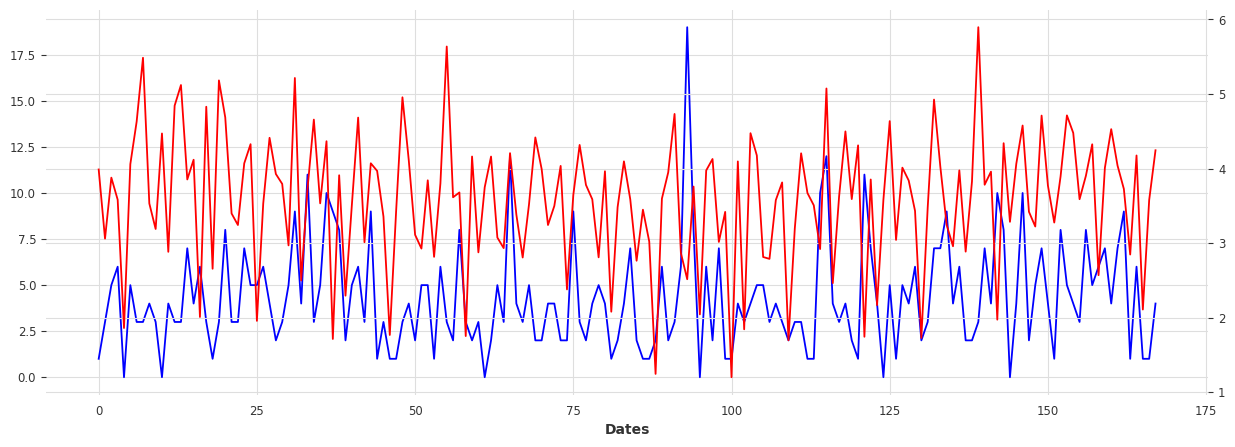

In [57]:
# Naive Seasonal
list_k = []
for m in range(2, 25):
    is_seasonal, period = check_seasonality(training_univariate, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))
        list_k.append(period)
k_chosen = max(list_k)

# Regression Ensemble
model = RegressionEnsembleModel(
    forecasting_models = [
        NaiveSeasonal(K=12),
        NaiveSeasonal(K=k_chosen),
        Prophet(
          add_seasonalities={
            'name':"quarterly_seasonality",
            'seasonal_periods':4,
            'fourier_order':5
            }
        ),
        RegressionModel(
          lags=[-5, -14],
          output_chunk_length=5,
          model=LGBMRegressor()
          )
    ],
    regression_train_n_points=20
)

# Pipeline
dct_results = pipeline_darts_univariate(
  model=model,
  train_darts=training_univariate,
  val_darts=validation_univariate,
  list_dates_val=list_dates_val,
  train_pipeline_univ=train_pipeline_univ
)

## 3. Univariate + covariates

In [58]:
## Forecasting - Univariate TS
# Choose TS
id_series = 0

# Preprocessing target
train_pipeline_univ = Pipeline(
    [
      train_filler,
      static_cov_transformer,
      train_scaler
    ]
)

training_univariate = train_pipeline_univ.fit_transform(df_train_fc[id_series])
validation_univariate = train_pipeline_univ.transform(df_val_fc[id_series])
list_dates_val = list(df_dates_val['date'].values)

# Preprocessing covariates
train_pipeline_cov = Pipeline(
    [
      train_filler,
      static_cov_transformer,
      train_scaler
    ]
)
covariates_train_ts = df_oil_train_fc[id_series]
covariates_train_ts = train_pipeline_cov.fit_transform(covariates_train_ts)

covariates_val_ts = df_oil_val_fc[id_series]
covariates_val_ts = train_pipeline_cov.transform(covariates_val_ts)


# Future covariates
covariates_future_train_ts = df_is_holiday_train_fc[id_series]
covariates_future_val_ts = df_is_holiday_val_fc[id_series]

# Preprocessing covariates
train_pipeline_future_cov = Pipeline(
    [
      train_filler,
      static_cov_transformer,
      train_scaler
    ]
)
covariates_future_train_ts = train_pipeline_future_cov.fit_transform(covariates_future_train_ts)
covariates_future_val_ts = train_pipeline_future_cov.fit_transform(covariates_future_val_ts)

In [59]:
# Future covariates (II)
future_cov_additional_2 = datetime_attribute_timeseries(
    concatenate([training_univariate, validation_univariate]),
    "month",
    cyclic=True,
    add_length=6
    )

In [ ]:
future_cov_additional_2

<TimeSeries (DataArray) (time: 1694, component: 2, sample: 1)>
array([[[ 0.5      ],
        [ 0.8660254]],

       [[ 0.5      ],
        [ 0.8660254]],

       [[ 0.5      ],
        [ 0.8660254]],

       ...,

       [[-0.8660254],
        [-0.5      ]],

       [[-0.8660254],
        [-0.5      ]],

       [[-0.8660254],
        [-0.5      ]]])
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2017-08-21
  * component  (component) object 'month_sin' 'month_cos'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
training_univariate

<TimeSeries (DataArray) (date: 1520, component: 1, sample: 1)>
array([[[0.        ]],

       [[0.11111111]],

       [[0.16666667]],

       ...,

       [[0.05555556]],

       [[0.16666667]],

       [[0.11111111]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-01 2013-01-02 ... 2017-02-28
  * component  (component) object 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  store_nbr  family  city  state  ty...
    hierarchy:          None

In [ ]:
covariates_train_ts

<TimeSeries (DataArray) (date: 1520, component: 1, sample: 1)>
array([[[0.79296459]],

       [[0.79296459]],

       [[0.79095108]],

       ...,

       [[0.32966165]],

       [[0.32985905]],

       [[0.32938529]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-01 2013-01-02 ... 2017-02-28
  * component  (component) object 'dcoilwtico'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  store_nbr  family  city  state  ty...
    hierarchy:          None

In [ ]:
concatenate([covariates_train_ts, covariates_val_ts])

<TimeSeries (DataArray) (date: 1688, component: 1, sample: 1)>
array([[[0.79296459]],

       [[0.79296459]],

       [[0.79095108]],

       ...,

       [[0.25828102]],

       [[0.25346441]],

       [[0.25322753]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-01 2013-01-02 ... 2017-08-15
  * component  (component) object 'dcoilwtico'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  store_nbr  family  city  state  ty...
    hierarchy:          None

Nb datapoints: 3040


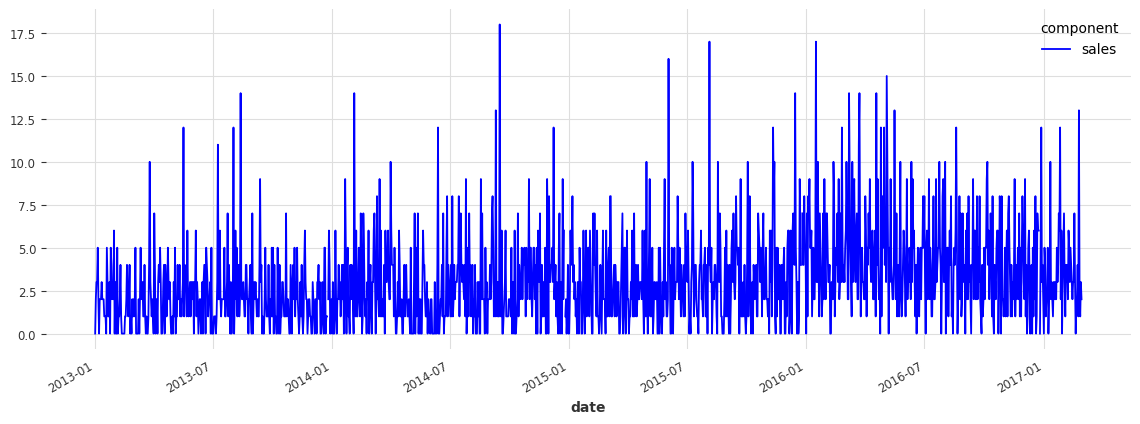

In [ ]:
# Plot TS
df_plot = pd.concat([
      df_train_fc[id_series].pd_dataframe(),
      df_train_fc[id_series].pd_dataframe(),
  ]
)
print("Nb datapoints:", len(df_plot))
df_plot.plot(figsize=(14,5), color="blue")
plt.show()

In [ ]:
# Linear regression (prueba)
model = LinearRegressionModel(
    lags=[-5],
    lags_past_covariates=[-2],
    output_chunk_length=5
)

model.fit(
    training_univariate,
    past_covariates=concatenate([covariates_train_ts, covariates_val_ts])
    )
predictions_univariate = model.predict(len(validation_univariate))

In [ ]:
# Linear regression (prueba - 2)
model = LinearRegressionModel(
    lags=[-5],
    lags_past_covariates=[-2],
    lags_future_covariates=[-2],
    output_chunk_length=5
)

model.fit(
    training_univariate,
    past_covariates=concatenate([covariates_train_ts, covariates_val_ts]),
    future_covariates=concatenate([covariates_future_train_ts, covariates_future_val_ts]),
    )
predictions_univariate = model.predict(
    len(validation_univariate),
    future_covariates=concatenate([covariates_future_train_ts, covariates_future_val_ts])
    )

MAPE: 0.213
MAE: 10.008
SMAPE: 21.280115365206303
R2: -0.023


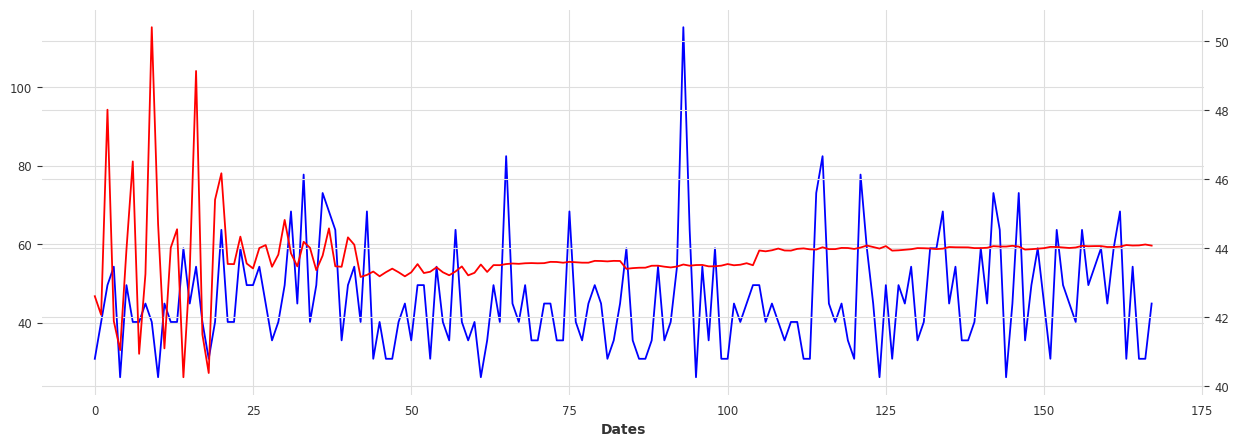

{'model_fit': LinearRegressionModel(lags=[-2, -5, -10], lags_past_covariates=[-5], lags_future_covariates=None, output_chunk_length=21, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True),
 'df_forecast':            date     y_test     y_pred
 0    2017-03-01  30.880556  42.610993
 1    2017-03-02  40.261667  42.071731
 2    2017-03-03  49.642778  48.016161
 3    2017-03-04  54.333333  41.889744
 4    2017-03-05  26.190000  41.047403
 ..          ...        ...        ...
 163  2017-08-11  30.880556  44.094208
 164  2017-08-12  54.333333  44.080602
 165  2017-08-13  30.880556  44.084410
 166  2017-08-14  30.880556  44.109886
 167  2017-08-15  44.952222  44.078061
 
 [168 rows x 3 columns]}

In [ ]:
# Linear regression
model = LinearRegressionModel(
    lags=[-2, -5, -10],
    lags_past_covariates=[-5],
    output_chunk_length=21
)

dct_results = pipeline_darts_univariate_covariates(
  model=model,
  train_darts=training_univariate,
  val_darts=validation_univariate,
  list_dates_val=list_dates_val,
  train_pipeline_univ=train_pipeline_univ,
  past_covariates=concatenate([covariates_train_ts, covariates_val_ts])
)

MAPE: 0.215
MAE: 10.103
SMAPE: 21.493220417881883
R2: -0.037


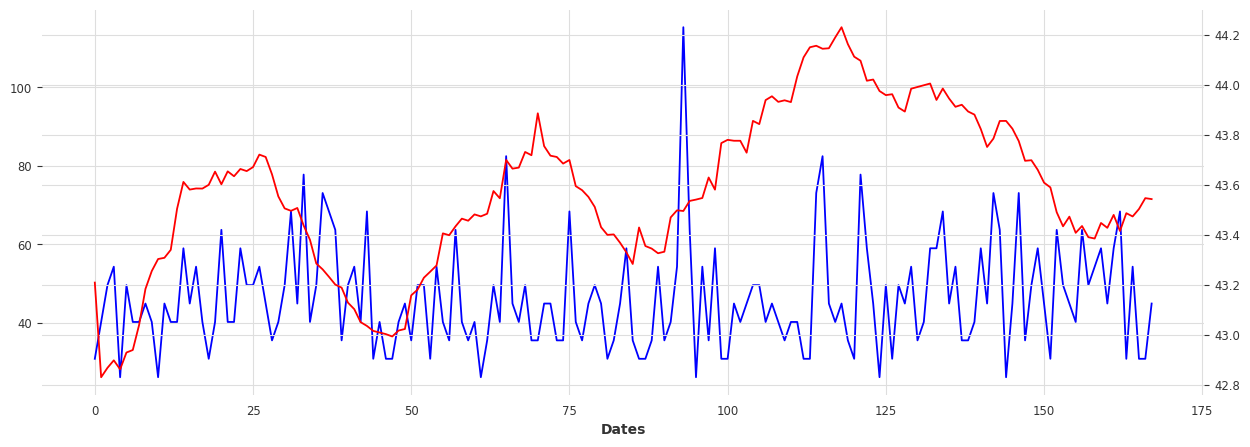

In [ ]:
# Ridge Regression
model = RegressionModel(
    lags=[-5],
    lags_past_covariates=[-6, -1],
    output_chunk_length=1,
    model=BayesianRidge()
    )

# Pipeline
dct_results = pipeline_darts_univariate_covariates(
  model=model,
  train_darts=training_univariate,
  val_darts=validation_univariate,
  list_dates_val=list_dates_val,
  train_pipeline_univ=train_pipeline_univ,
  past_covariates=concatenate([covariates_train_ts, covariates_val_ts])
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 1506, number of used features: 4
[LightGBM] [Info] Start training from score 0.174838
MAPE: 0.239
MAE: 11.073
SMAPE: 23.68283720218208
R2: -0.16


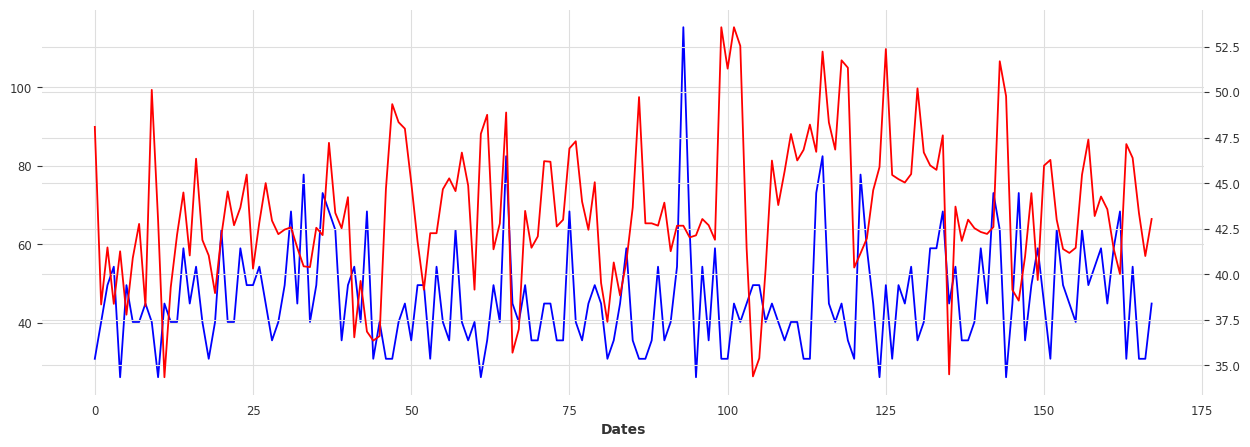

In [ ]:
# LightGBM
model = RegressionModel(
    lags=[-5, -14],
    lags_past_covariates=[-6, -1],
    output_chunk_length=1,
    model=LGBMRegressor()
    )

# Pipeline
dct_results = pipeline_darts_univariate_covariates(
  model=model,
  train_darts=training_univariate,
  val_darts=validation_univariate,
  list_dates_val=list_dates_val,
  train_pipeline_univ=train_pipeline_univ,
  past_covariates=concatenate([covariates_train_ts, covariates_val_ts])
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.1 M 
---------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.474    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE: 0.24
MAE: 11.464
SMAPE: 25.020025954700934
R2: -0.265


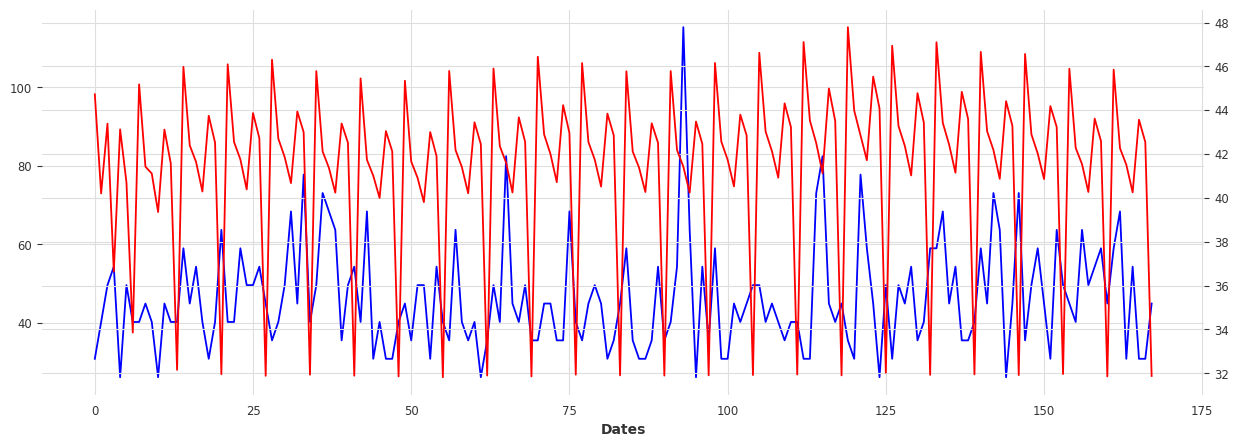

In [ ]:
# NBEATS
model = NBEATSModel(
    input_chunk_length=7,
    output_chunk_length=7,
    n_epochs=10,
    random_state=0
)

# Pipeline
dct_results = pipeline_darts_univariate_covariates(
  model=model,
  train_darts=training_univariate,
  val_darts=validation_univariate,
  list_dates_val=list_dates_val,
  train_pipeline_univ=train_pipeline_univ,
  past_covariates=concatenate([covariates_train_ts, covariates_val_ts])
)

##### Past & Future covariates

MAPE: 30733128982859.965
MAE: 0.119
SMAPE: 55.24907238148302
R2: -0.045


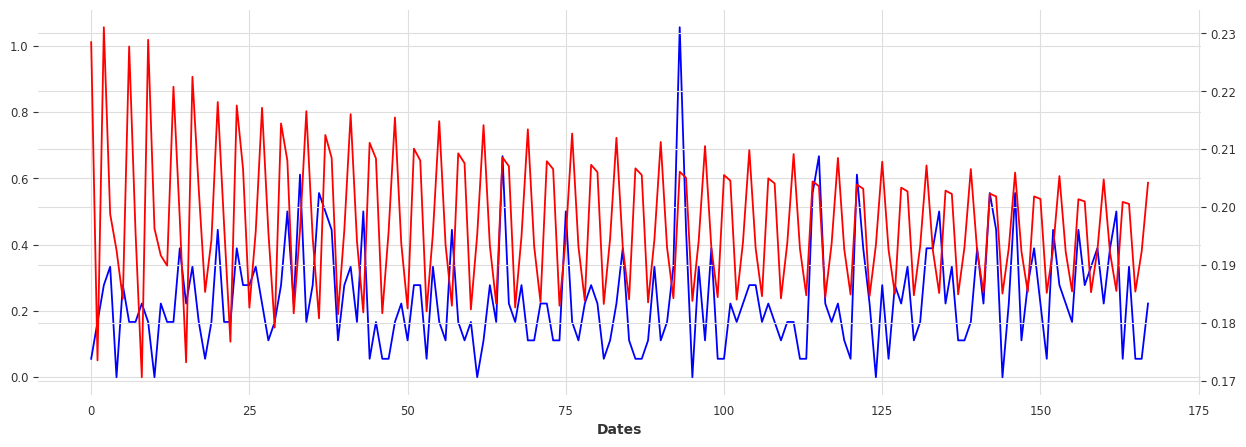

In [ ]:
# AutoArima
model = AutoARIMA(
    start_p=8,
    max_p=12,
    start_q=1
    )
model.fit(
    training_univariate,
    future_covariates=concatenate([covariates_future_train_ts, covariates_future_val_ts])
    )
predictions_univariate = model.predict(
    len(validation_univariate),
    future_covariates=concatenate([covariates_future_train_ts, covariates_future_val_ts])
    )
dct_metrics = pipeline_darts_metrics(
    predictions_univariate=train_pipeline_univ.inverse_transform(predictions_univariate, partial=True),
    val_darts=train_pipeline_univ.inverse_transform(validation_univariate, partial=True),
    list_dates_val=list_dates_val
    )
# future_cov_additional_2 -> other possible future covariates

MAPE: 32818236198841.93
MAE: 0.121
SMAPE: 55.67303901742071
R2: -0.049


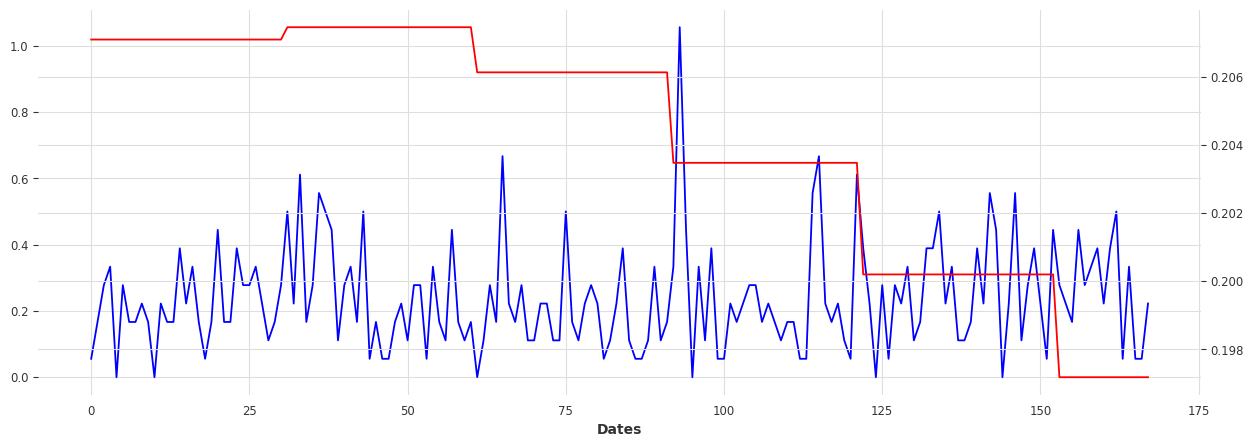

In [ ]:
# AutoArima (II)
model = AutoARIMA(
    start_p=8,
    max_p=12,
    start_q=1
    )
model.fit(
    training_univariate,
    future_covariates=future_cov_additional_2
    )
predictions_univariate = model.predict(
    len(validation_univariate),
    future_covariates=future_cov_additional_2
    )
dct_metrics = pipeline_darts_metrics(
    predictions_univariate=train_pipeline_univ.inverse_transform(predictions_univariate, partial=True),
    val_darts=train_pipeline_univ.inverse_transform(validation_univariate, partial=True),
    list_dates_val=list_dates_val
    )

MAPE: 32343230296421.094
MAE: 0.121
SMAPE: 55.81500594893319
R2: -0.062


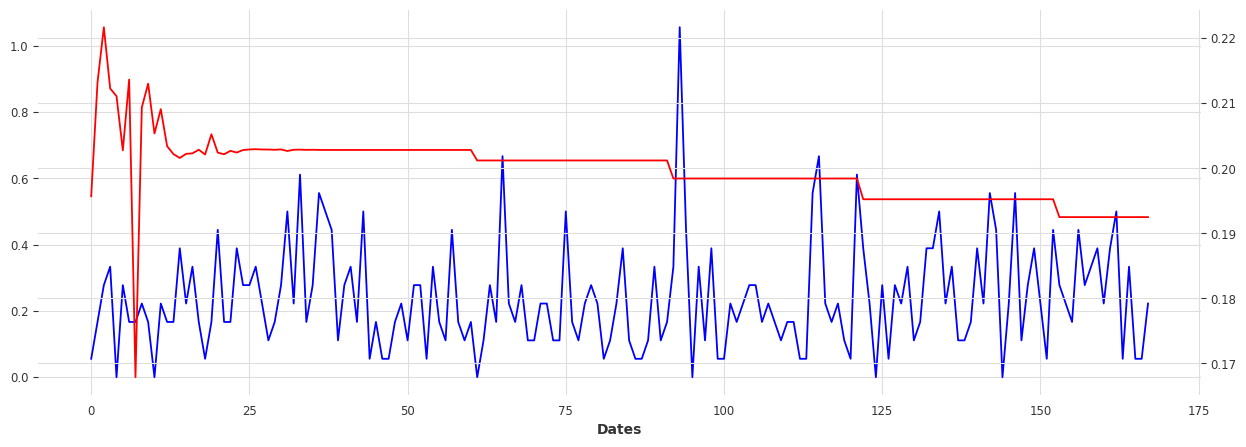

In [ ]:
# AutoArima (III)
model = StatsForecastAutoARIMA(
  season_length=12
)
model.fit(
    training_univariate,
    future_covariates=future_cov_additional_2
    )
predictions_univariate = model.predict(
    len(validation_univariate),
    future_covariates=future_cov_additional_2
    )
dct_metrics = pipeline_darts_metrics(
    predictions_univariate=train_pipeline_univ.inverse_transform(predictions_univariate, partial=True),
    val_darts=train_pipeline_univ.inverse_transform(validation_univariate, partial=True),
    list_dates_val=list_dates_val
    )

MAPE: 33532208960226.32
MAE: 0.119
SMAPE: 55.01589343766087
R2: -0.035


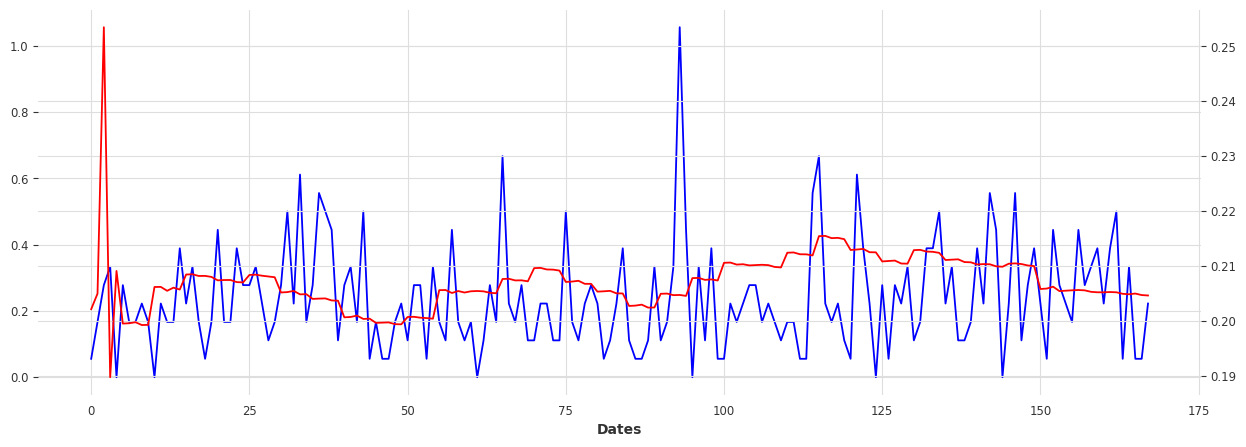

In [ ]:
# Linear regression - covariates past & future
model = LinearRegressionModel(
    lags=[-5],
    lags_past_covariates=[-2],
    lags_future_covariates=[-2, -1, 0],
    output_chunk_length=5
)

# Pipeline
model.fit(
    training_univariate,
    past_covariates=concatenate([covariates_train_ts, covariates_val_ts]),
    future_covariates=concatenate([covariates_future_train_ts, covariates_future_val_ts]),
    )
predictions_univariate = model.predict(
    len(validation_univariate),
    future_covariates=concatenate([covariates_future_train_ts, covariates_future_val_ts])
    )

dct_metrics = pipeline_darts_metrics(
    predictions_univariate=train_pipeline_univ.inverse_transform(predictions_univariate, partial=True),
    val_darts=train_pipeline_univ.inverse_transform(validation_univariate, partial=True),
    list_dates_val=list_dates_val
    )

MAPE: 32980665627834.883
MAE: 0.12
SMAPE: 55.18886856130076
R2: -0.037


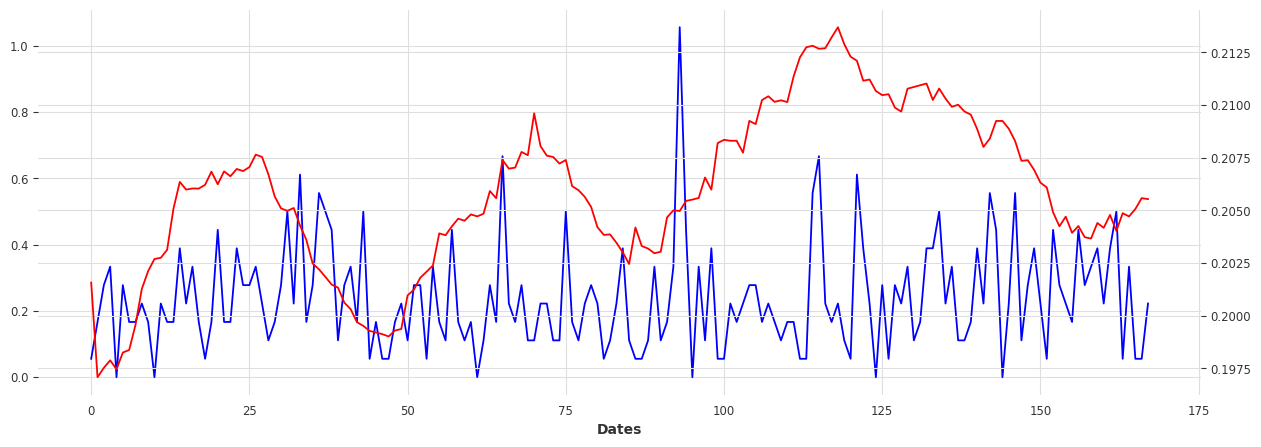

In [ ]:
# Ridge Regression
model = RegressionModel(
    lags=[-5],
    lags_past_covariates=[-6, -1],
    lags_future_covariates=[-2, -1, 0],
    output_chunk_length=1,
    model=BayesianRidge()
    )

# Pipeline
model.fit(
    training_univariate,
    past_covariates=concatenate([covariates_train_ts, covariates_val_ts]),
    future_covariates=concatenate([covariates_future_train_ts, covariates_future_val_ts]),
    )
predictions_univariate = model.predict(
    len(validation_univariate),
    future_covariates=concatenate([covariates_future_train_ts, covariates_future_val_ts])
    )

dct_metrics = pipeline_darts_metrics(
    predictions_univariate=train_pipeline_univ.inverse_transform(predictions_univariate, partial=True),
    val_darts=train_pipeline_univ.inverse_transform(validation_univariate, partial=True),
    list_dates_val=list_dates_val
    )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 525
[LightGBM] [Info] Number of data points in the train set: 1514, number of used features: 3
[LightGBM] [Info] Start training from score 0.174464
MAPE: 33890354089374.395
MAE: 0.139
SMAPE: 65.45668916207997
R2: -0.303


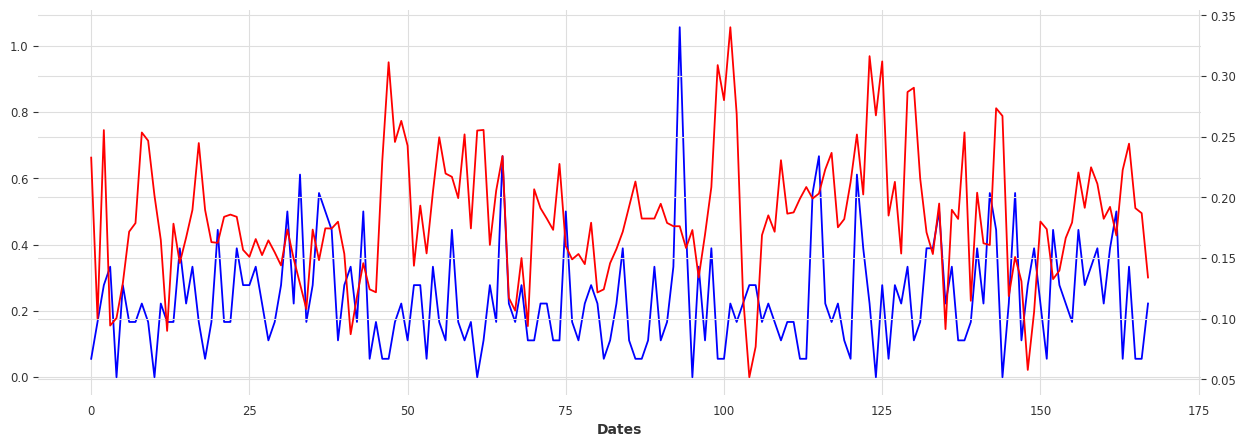

In [ ]:
# LightGBM
model = RegressionModel(
    lags=[-5],
    lags_past_covariates=[-6, -1],
    lags_future_covariates=[-2, -1, 0],
    output_chunk_length=1,
    model=LGBMRegressor()
    )

# Pipeline
model.fit(
    training_univariate,
    past_covariates=concatenate([covariates_train_ts, covariates_val_ts]),
    future_covariates=concatenate([covariates_future_train_ts, covariates_future_val_ts]),
    )
predictions_univariate = model.predict(
    len(validation_univariate),
    future_covariates=concatenate([covariates_future_train_ts, covariates_future_val_ts])
    )

dct_metrics = pipeline_darts_metrics(
    predictions_univariate=train_pipeline_univ.inverse_transform(predictions_univariate, partial=True),
    val_darts=train_pipeline_univ.inverse_transform(validation_univariate, partial=True),
    list_dates_val=list_dates_val
    )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 725   
4 | V             | Linear           | 26    
---------------------------------------------------
751       Trainable params
0         Non-trainable params
751       Total params
0.003     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE: 23053840040022.46
MAE: 0.137
SMAPE: 67.0154023444543
R2: -0.476


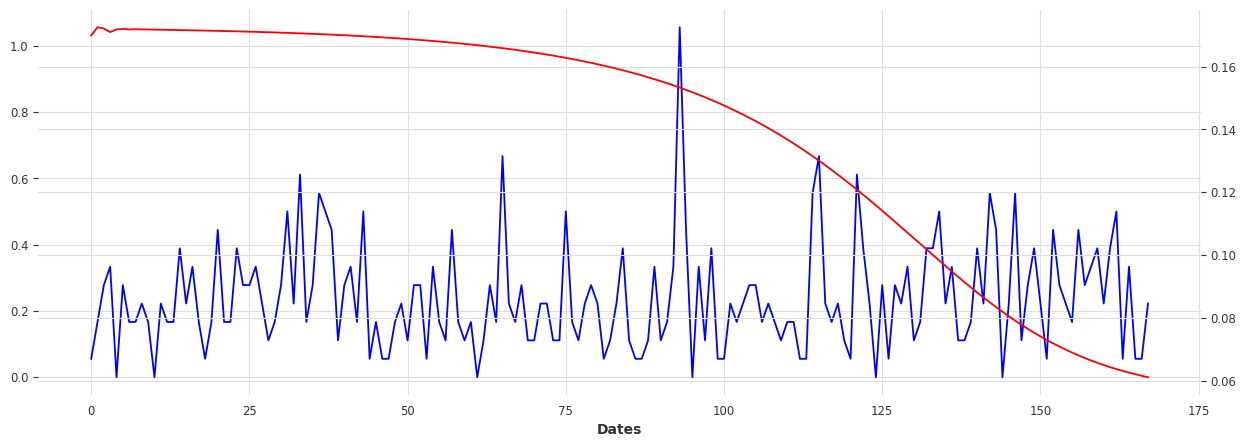

In [43]:
# RNN model
model = RNNModel(
    input_chunk_length=10,
    output_chunk_length=7,
    n_epochs=10,
    random_state=0
    )

# Pipeline
model.fit(
  training_univariate,
  future_covariates=concatenate([covariates_future_train_ts, covariates_future_val_ts])
)
predictions_univariate = model.predict(
    len(validation_univariate),
    future_covariates=concatenate([covariates_future_train_ts, covariates_future_val_ts])
    )
dct_metrics = pipeline_darts_metrics(
    predictions_univariate=train_pipeline_univ.inverse_transform(predictions_univariate, partial=True),
    val_darts=train_pipeline_univ.inverse_transform(validation_univariate, partial=True),
    list_dates_val=list_dates_val
    )

There is seasonality of order 3.
There is seasonality of order 7.
There is seasonality of order 11.
There is seasonality of order 14.
There is seasonality of order 18.
There is seasonality of order 21.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 525
[LightGBM] [Info] Number of data points in the train set: 1464, number of used features: 3
[LightGBM] [Info] Start training from score 0.173440


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 525
[LightGBM] [Info] Number of data points in the train set: 1514, number of used features: 3
[LightGBM] [Info] Start training from score 0.174464


MAPE: 47694559815898.95
MAE: 0.146
SMAPE: 61.11629356120327
R2: -0.274


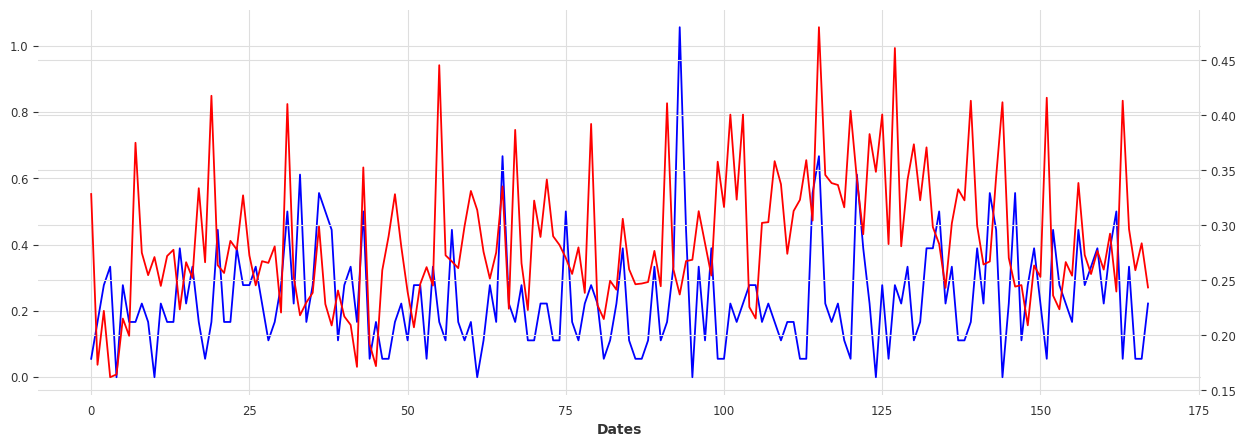

In [63]:
# Naive Seasonal
list_k = []
for m in range(2, 25):
    is_seasonal, period = check_seasonality(training_univariate, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))
        list_k.append(period)
k_chosen = max(list_k)

# Regression Ensemble
model = RegressionEnsembleModel(
    forecasting_models = [
        NaiveSeasonal(K=12),
        NaiveSeasonal(K=k_chosen),
        RegressionModel(
          lags=[-5],
          lags_past_covariates=[-6, -1],
          lags_future_covariates=[-2, -1, 0],
          output_chunk_length=1,
          model=BayesianRidge()
          ),
        RegressionModel(
            lags=[-5],
            lags_past_covariates=[-6, -1],
            lags_future_covariates=[-2, -1, 0],
            output_chunk_length=1,
            model=LGBMRegressor()
        )
    ],
    regression_train_n_points=50
)

# Pipeline
model.fit(
    training_univariate,
    past_covariates=concatenate([covariates_train_ts, covariates_val_ts]),
    future_covariates=concatenate([covariates_future_train_ts, covariates_future_val_ts]),
    )
predictions_univariate = model.predict(
    len(validation_univariate),
    future_covariates=concatenate([covariates_future_train_ts, covariates_future_val_ts])
    )

dct_metrics = pipeline_darts_metrics(
    predictions_univariate=train_pipeline_univ.inverse_transform(predictions_univariate, partial=True),
    val_darts=train_pipeline_univ.inverse_transform(validation_univariate, partial=True),
    list_dates_val=list_dates_val
    )

#### Prophet comparison

DEBUG:cmdstanpy:input tempfile: /tmp/tmp52tupg85/uz87xiip.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp52tupg85/tzvs9mr9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97310', 'data', 'file=/tmp/tmp52tupg85/uz87xiip.json', 'init=/tmp/tmp52tupg85/tzvs9mr9.json', 'output', 'file=/tmp/tmp52tupg85/prophet_modelqt95sonw/prophet_model-20240217211304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:13:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:13:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAPE: 32337079691272.0
MAE: 0.122
SMAPE: 55.19543417918974
R2: 0.038


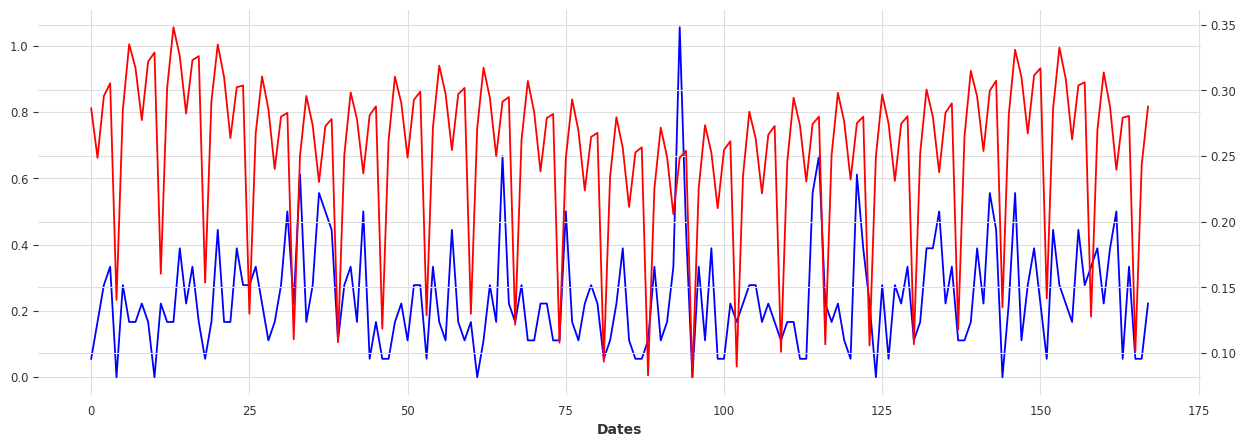

In [ ]:
# Prophet
model = Prophet(
  yearly_seasonality = True,
  weekly_seasonality = True,
  daily_seasonality = True,
  seasonality_mode = 'multiplicative',
  holidays_prior_scale = 0.1
)

# Pipeline
model.fit(
    training_univariate,
    future_covariates=concatenate([covariates_future_train_ts, covariates_future_val_ts]),
    )
predictions_univariate = model.predict(
    len(validation_univariate),
    future_covariates=concatenate([covariates_future_train_ts, covariates_future_val_ts])
    )

dct_metrics = pipeline_darts_metrics(
    predictions_univariate=train_pipeline_univ.inverse_transform(predictions_univariate, partial=True),
    val_darts=train_pipeline_univ.inverse_transform(validation_univariate, partial=True),
    list_dates_val=list_dates_val
    )

In [ ]:
# Check Prophet
cod_store = '1'

df_input_train_prophet = (
    df_train_sp[
        (df_train_sp['store_nbr']==cod_store)
    ][['date', 'sales']]
    .copy()
    .rename(columns={'date':'ds', 'sales':'y'})
)
df_input_val_prophet = (
    df_val_sp[
        (df_train_sp['store_nbr']==cod_store)
    ][['date', 'sales']]
    .copy()
    .rename(columns={'date':'ds', 'sales':'y'})
)

<ipython-input-126-0a962273a3d3>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_val_sp[


In [ ]:
model = fb_Prophet(
    yearly_seasonality = True,
    weekly_seasonality = True,
    daily_seasonality = True,
    seasonality_mode = 'multiplicative',
    holidays_prior_scale = 0.1
)
model.fit(df_input_train_prophet)

future = model.make_future_dataframe(periods=len(df_input_val_prophet))
forecast = model.predict(future)

forecast['ds'] = forecast['ds'].astype(str)
df_input_val_prophet['ds'] = df_input_val_prophet['ds'].astype(str)
forecast = forecast.merge(df_input_val_prophet[['ds']], how="inner")

DEBUG:cmdstanpy:input tempfile: /tmp/tmp52tupg85/b5k7j9qt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp52tupg85/6lxc6ty3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52409', 'data', 'file=/tmp/tmp52tupg85/b5k7j9qt.json', 'init=/tmp/tmp52tupg85/6lxc6ty3.json', 'output', 'file=/tmp/tmp52tupg85/prophet_modelrinsjsn2/prophet_model-20240217211243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:12:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:12:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAPE: 586077538152711.4
MAE: 2.206
SMAPE: 55.30743354620701
R2: 0.034


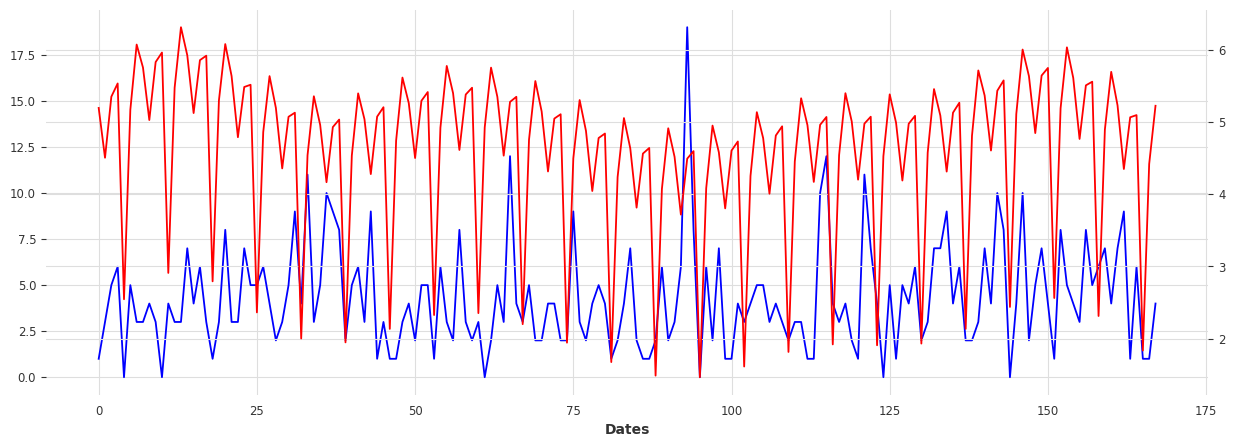

In [ ]:
# Evaluate
df_forecast = pd.DataFrame(
    {
        'date': list_dates_val,
        'y_test': list([x[0] for x in df_input_val_prophet[['y']].values]),
        'y_pred': list([x[0] for x in forecast[['yhat']].values])
    }
)
mape_metric = np.round(
    mean_absolute_percentage_error(
        df_forecast['y_test'].values,
        df_forecast['y_pred'].values
        ), 3)
mae_metric = np.round(
    mean_absolute_error(
        df_forecast['y_test'].values,
        df_forecast['y_pred'].values
        ), 3)
smape_metric = smape(
    df_forecast['y_test'].values,
    df_forecast['y_pred'].values
)
r2_metric = np.round(
    r2_score(df_forecast['y_test'].values, df_forecast['y_pred'].values), 3
    )
print(f"MAPE: {mape_metric}")
print(f"MAE: {mae_metric}")
print(f"SMAPE: {smape_metric}")
print(f"R2: {r2_metric}")

# Plot results
plt.figure(figsize=(15, 5))
plt.xlabel('Dates')

ax1 = df_forecast.y_test.plot(color='blue', grid=True, label='y_test')
ax2 = df_forecast.y_pred.plot(color='red', grid=True, secondary_y=True, label='y_pred')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.show()

#### Prophet forecasting

In [76]:
# Check Prophet
cod_store = '1'

df_input_train_prophet = (
    df_train_sp[
        (df_train_sp['store_nbr']==cod_store)
    ]
    .copy()
    .rename(columns={'date':'ds', 'sales':'y'})
    .fillna(0)
)
df_input_val_prophet = (
    df_val_sp[
        (df_train_sp['store_nbr']==cod_store)
    ]
    .copy()
    .rename(columns={'date':'ds', 'sales':'y'})
    .fillna(0)
)

<ipython-input-76-075aa09b88dd>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_val_sp[


In [74]:
print(len(df_input_train_prophet), len(df_input_train_prophet[['ds']].drop_duplicates()))

1516 1516


In [83]:
df_input_train_prophet.head(5)

id          ds store_nbr      family    y  onpromotion   city  \
0       0  2013-01-01         1  AUTOMOTIVE  0.0            0  Quito   
54   1782  2013-01-02         1  AUTOMOTIVE  2.0            0  Quito   
108  3564  2013-01-03         1  AUTOMOTIVE  3.0            0  Quito   
162  5346  2013-01-04         1  AUTOMOTIVE  3.0            0  Quito   
216  7128  2013-01-05         1  AUTOMOTIVE  5.0            0  Quito   

         state type cluster       locale  locale_name  description  \
0    Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday   
54   Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday   
108  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday   
162  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday   
216  Pichincha    D      13  Not Holiday  Not Holiday  Not Holiday   

    transferred  dcoilwtico  month  day_of_month  day_of_year  week_of_month  \
0         False        0.00      1             1            1              1   
54        False       93.14      1             2            2              1   
108       False       92.97      1             3            3              1   
162       False       93.12      1             4            4              1   
216       False        0.00      1             5            5              1   

     week_of_year  day_of_week  year  is_wknd  quarter  is_month_start  \
0               1            2  2013        0        1               1   
54              1            3  2013        0        1               0   
108             1            4  2013        0        1               0   
162             1            5  2013        1        1               0   
216             1            6  2013        1        1               0   

     is_month_end  is_quarter_start  is_quarter_end  is_year_start  \
0               0                 1               0              1   
54              0                 0               0              0   
108             0                 0               0              0   
162             0                 0               0              0   
216             0                 0               0              0   

     is_year_end  season  type_holiday_Holiday  type_holiday_Not Holiday  
0              0       0                     0                         1  
54             0       0                     0                         1  
108            0       0                     0                         1  
162            0       0                     0                         1  
216            0       0                     0                         1

In [108]:
# Base model
model = fb_Prophet(
    yearly_seasonality = True,
    weekly_seasonality = True,
    daily_seasonality = True,
    seasonality_mode = 'additive',
    #holidays_prior_scale = 0.1
)

# Add regressors
list_regressors = [
    'onpromotion',
    'day_of_week',
    'week_of_year',
    'week_of_month',
    'dcoilwtico',
    'is_month_start',
    'is_wknd',
    'season',
    'type_holiday_Holiday'
]
for regressor in list_regressors:
  model.add_regressor(regressor)

# Fit model
model.fit(df_input_train_prophet)

# Get predictions
future = model.make_future_dataframe(periods=len(df_input_val_prophet))
future['ds'] = future['ds'].astype(str)
df_input_val_prophet['ds'] = df_input_val_prophet['ds'].astype(str)
future = (
  future.merge(
      df_input_val_prophet[['ds'] + list_regressors],
      how="inner",
      left_on=['ds'],
      right_on=['ds']
      )
)
forecast = model.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgsl4gvj/nek1fucl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgsl4gvj/gnox34kb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98471', 'data', 'file=/tmp/tmpqgsl4gvj/nek1fucl.json', 'init=/tmp/tmpqgsl4gvj/gnox34kb.json', 'output', 'file=/tmp/tmpqgsl4gvj/prophet_modelb84b9mfm/prophet_model-20240218195543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:55:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:55:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAPE: 514710340051523.06
MAE: 2.082
SMAPE: 53.58666513938554
R2: 0.07


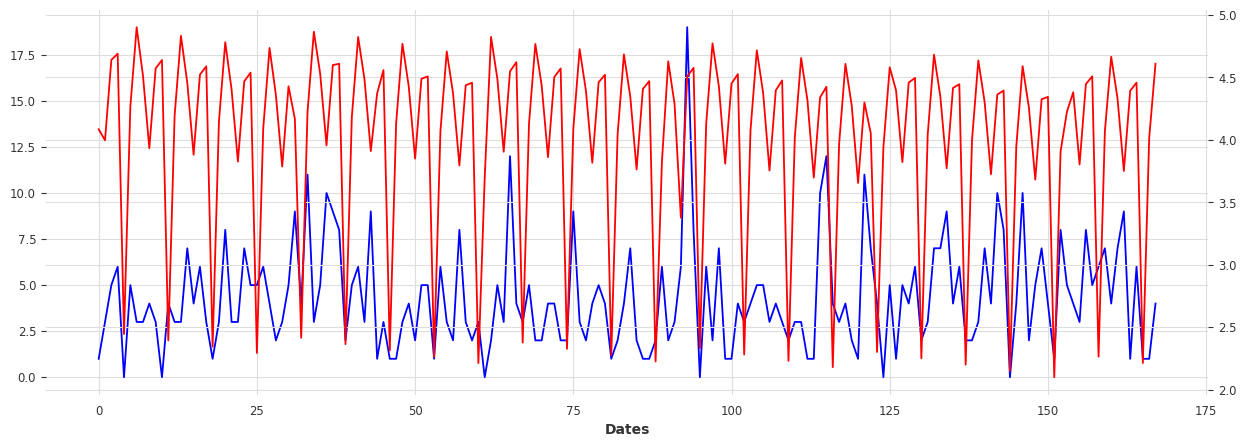

In [109]:
# Evaluate
df_forecast = pd.DataFrame(
    {
        'date': list_dates_val,
        'y_test': list([x[0] for x in df_input_val_prophet[['y']].values]),
        'y_pred': list([x[0] for x in forecast[['yhat']].values])
    }
)
mape_metric = np.round(
    mean_absolute_percentage_error(
        df_forecast['y_test'].values,
        df_forecast['y_pred'].values
        ), 3)
mae_metric = np.round(
    mean_absolute_error(
        df_forecast['y_test'].values,
        df_forecast['y_pred'].values
        ), 3)
smape_metric = smape(
    df_forecast['y_test'].values,
    df_forecast['y_pred'].values
)
r2_metric = np.round(
    r2_score(df_forecast['y_test'].values, df_forecast['y_pred'].values), 3
    )
print(f"MAPE: {mape_metric}")
print(f"MAE: {mae_metric}")
print(f"SMAPE: {smape_metric}")
print(f"R2: {r2_metric}")

# Plot results
plt.figure(figsize=(15, 5))
plt.xlabel('Dates')

ax1 = df_forecast.y_test.plot(color='blue', grid=True, label='y_test')
ax2 = df_forecast.y_pred.plot(color='red', grid=True, secondary_y=True, label='y_pred')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.show()

In [98]:
#print(len(forecast))
#print(len(list([x for x in pd.concat([df_input_train_prophet[['ds', 'y'] + list_regressors], df_input_val_prophet[['ds', 'y'] + list_regressors]])['y'].values])))

1684
1684


MAPE: 1410031877186903.8
MAE: 1.868
SMAPE: 70.83946807116304
R2: 0.171


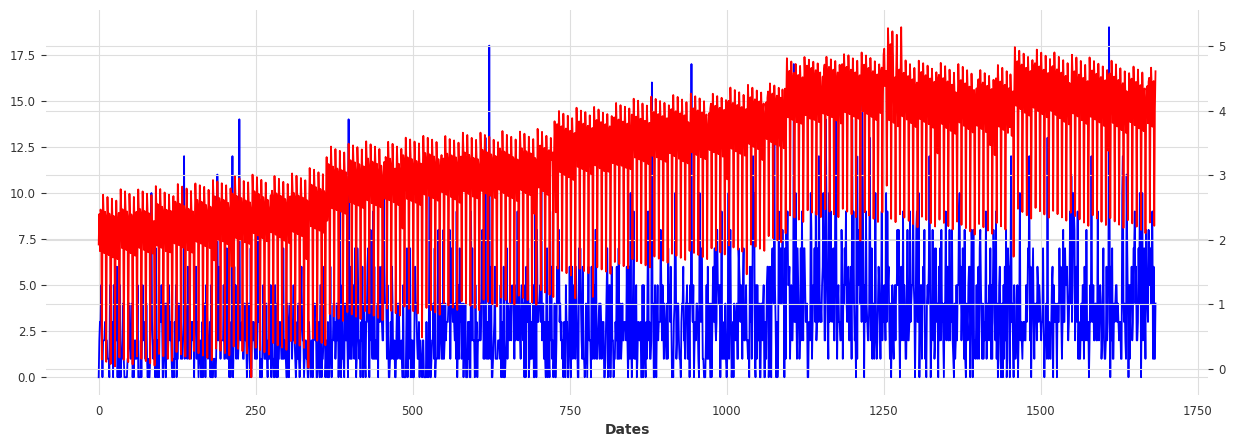

In [110]:
## Visualize over all dataset

# Get predictions
future = model.make_future_dataframe(periods=len(df_input_val_prophet))
future['ds'] = future['ds'].astype(str)
df_input_val_prophet['ds'] = df_input_val_prophet['ds'].astype(str)
future = (
  future.merge(
      pd.concat([df_input_train_prophet[['ds'] + list_regressors], df_input_val_prophet[['ds'] + list_regressors]]),
      how="inner",
      left_on=['ds'],
      right_on=['ds']
      )
)
forecast = model.predict(future)

# Evaluate
df_forecast = pd.DataFrame(
    {
        'date': future['ds'].values,
        'y_test': list([x for x in pd.concat([df_input_train_prophet[['ds', 'y'] + list_regressors], df_input_val_prophet[['ds', 'y'] + list_regressors]])['y'].values]),
        'y_pred': list([x[0] for x in forecast[['yhat']].values])
    }
)
mape_metric = np.round(
    mean_absolute_percentage_error(
        df_forecast['y_test'].values,
        df_forecast['y_pred'].values
        ), 3)
mae_metric = np.round(
    mean_absolute_error(
        df_forecast['y_test'].values,
        df_forecast['y_pred'].values
        ), 3)
smape_metric = smape(
    df_forecast['y_test'].values,
    df_forecast['y_pred'].values
)
r2_metric = np.round(
    r2_score(df_forecast['y_test'].values, df_forecast['y_pred'].values), 3
    )
print(f"MAPE: {mape_metric}")
print(f"MAE: {mae_metric}")
print(f"SMAPE: {smape_metric}")
print(f"R2: {r2_metric}")

# Plot results
plt.figure(figsize=(15, 5))
plt.xlabel('Dates')

ax1 = df_forecast.y_test.plot(color='blue', grid=True, label='y_test')
ax2 = df_forecast.y_pred.plot(color='red', grid=True, secondary_y=True, label='y_pred')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.show()

In [ ]:
# Hyperparameter tuning
import itertools
import numpy as np
import pandas as pd
from prophet.diagnostics import performance_metrics, cross_validation

param_grid = {
    'yearly_seasonality': [True],
    'weekly_seasonality': [True],
    'daily_seasonality': [True],
    'seasonality_mode': ['additive'],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = fb_Prophet(**params).fit(df_input_train_prophet[['ds', 'y']])  # Fit model with given params
    df_cv = cross_validation(
        m,
        #cutoffs=cutoffs,
        horizon='30 days',
        parallel="processes"
        )
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgsl4gvj/zds451t8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgsl4gvj/4w7z26m3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83065', 'data', 'file=/tmp/tmpqgsl4gvj/zds451t8.json', 'init=/tmp/tmpqgsl4gvj/4w7z26m3.json', 'output', 'file=/tmp/tmpqgsl4gvj/prophet_model_6xq66h4/prophet_model-20240218200110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:01:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:01:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 75 forecasts with cutoffs between 2014-01-15 00:00:00 and 2017-01-29 00:00:00
INFO:prophet:Applying in parallel with <conc

## 4. Multivariate forecasting



In [ ]:
def fit_and_pred(model, training, validation):
    model.fit(training)
    forecast = model.predict(len(validation))
    return forecast

In [39]:
train_pipeline = Pipeline(
    [
      train_filler,
      static_cov_transformer,
      train_scaler
    ]
)

training_transformed = train_pipeline.fit_transform(df_train_fc)
validation_transformed = train_pipeline.transform(df_val_fc)

In [ ]:
training_transformed[0]

<TimeSeries (DataArray) (date: 1520, component: 1, sample: 1)>
array([[[0.        ]],

       [[0.11111111]],

       [[0.16666667]],

       ...,

       [[0.05555556]],

       [[0.16666667]],

       [[0.11111111]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-01 2013-01-02 ... 2017-02-28
  * component  (component) object 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  store_nbr_1  store_nbr_10  store_n...
    hierarchy:          None

```
# training and prediction with the VARIMA model
model_VARIMA = VARIMA(
    p=12,
    d=0,
    q=0,
    trend="n"
    )
forecast_VARIMA = fit_and_pred(
    model_VARIMA,
    [training_transformed[0], training_transformed[1]],
    [validation_transformed[0], validation_transformed[1]]
    )

```

In [ ]:
# RNN model
model = RNNModel(
    input_chunk_length=10,
    output_chunk_length=7,
    n_epochs=10,
    random_state=0
    )
model.fit(training_transformed)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | V             | Linear           | 26    
---------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


RNNModel(model=RNN, hidden_dim=25, n_rnn_layers=1, dropout=0.0, training_length=24, input_chunk_length=10, output_chunk_length=7, n_epochs=10, random_state=0)

In [ ]:
# Evaluate results
forecast = model.predict(
    n = len(validation_transformed[0]),
    series = training_transformed
    )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

**************************************************
Analysis for: 0
MAPE: 607198513939108.8
MAE: 2.202
SMAPE: 55.06428423123163
R2: 0.04


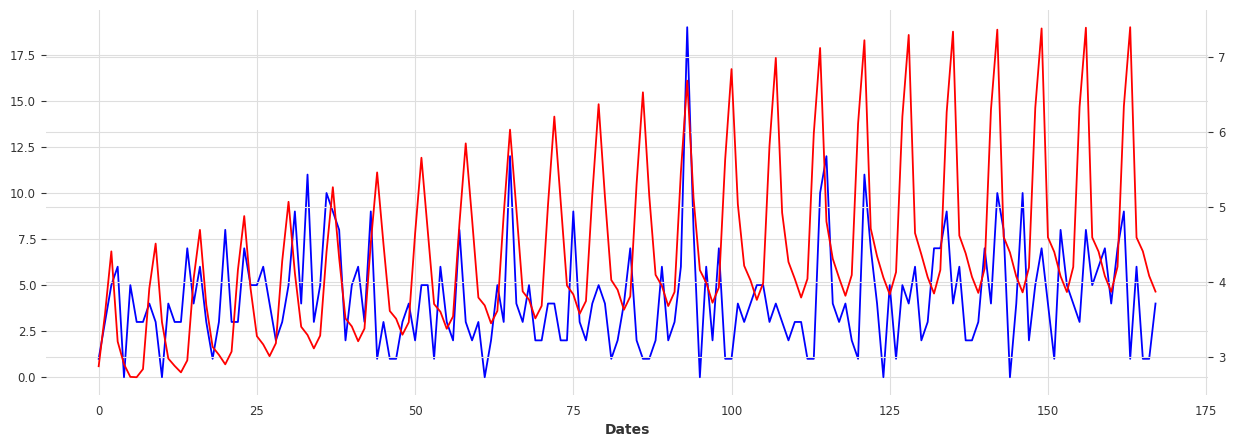

**************************************************

**************************************************
Analysis for: 1
MAPE: 5701954793474073.0
MAE: 4.698
SMAPE: 108.36100699463037
R2: -4.275


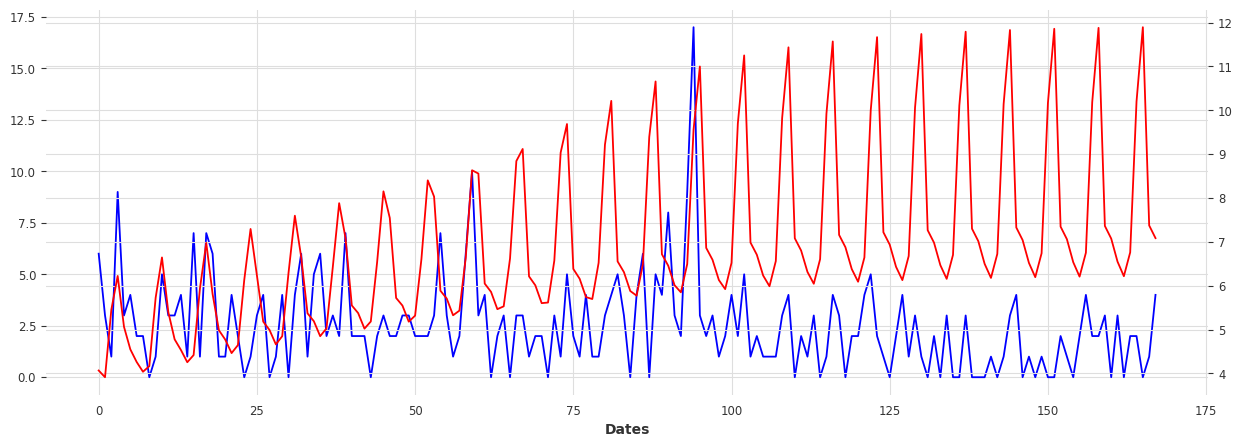

**************************************************

**************************************************
Analysis for: 7
MAPE: 630777637161903.2
MAE: 2.651
SMAPE: 55.304560051072436
R2: -0.184


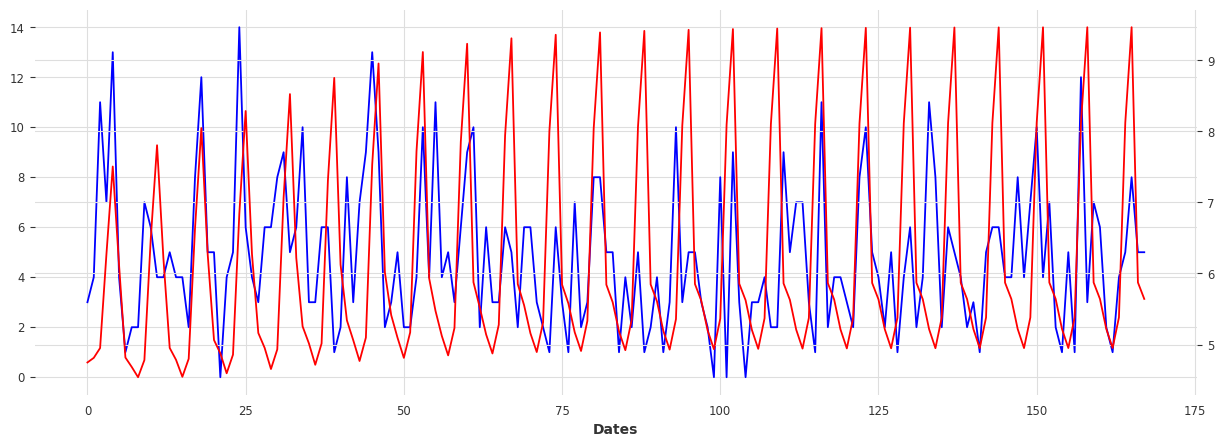

**************************************************



In [ ]:
## Metrics for one series
# Choose TS
list_series_check  = [0, 1, 7]
for id_series in list_series_check:
  print("*"*50)
  print("Analysis for:", id_series)
  # Get metrics
  dct_metrics = pipeline_darts_metrics(
      predictions_univariate=train_pipeline.inverse_transform(forecast, partial=True)[id_series],
      val_darts=train_pipeline.inverse_transform(validation_transformed, partial=True)[id_series],
      list_dates_val=list_dates_val
      )
  print("*"*50)
  print()

In [ ]:
# NBEATS
model = NBEATSModel(
    input_chunk_length=7,
    output_chunk_length=7,
    n_epochs=2,
    random_state=0
)
model.fit(training_transformed)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.1 M 
---------------------------------------------------
6.1 M     Trainable params
1.3 K     Non-trainable params
6.1 M     Total params
24.249    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=7, output_chunk_length=7, n_epochs=2, random_state=0)

In [ ]:
# Evaluate results
forecast = model.predict(
    n = len(validation_transformed[0]),
    series = training_transformed
    )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

**************************************************
Analysis for: 0
MAPE: 570732639468834.5
MAE: 2.131
SMAPE: 54.82657052351087
R2: -0.063


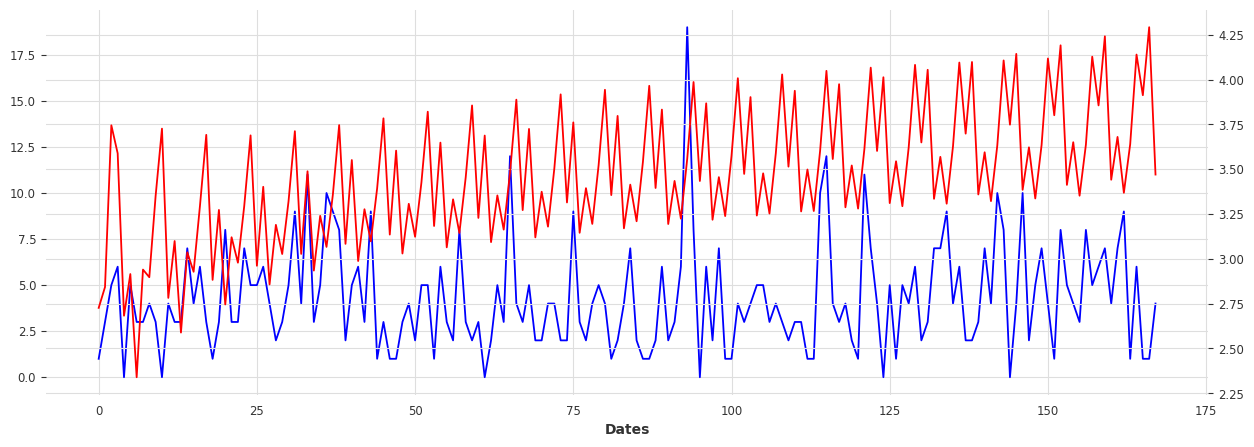

**************************************************

**************************************************
Analysis for: 1
MAPE: 4439635131537300.0
MAE: 3.35
SMAPE: 97.01889064749722
R2: -1.66


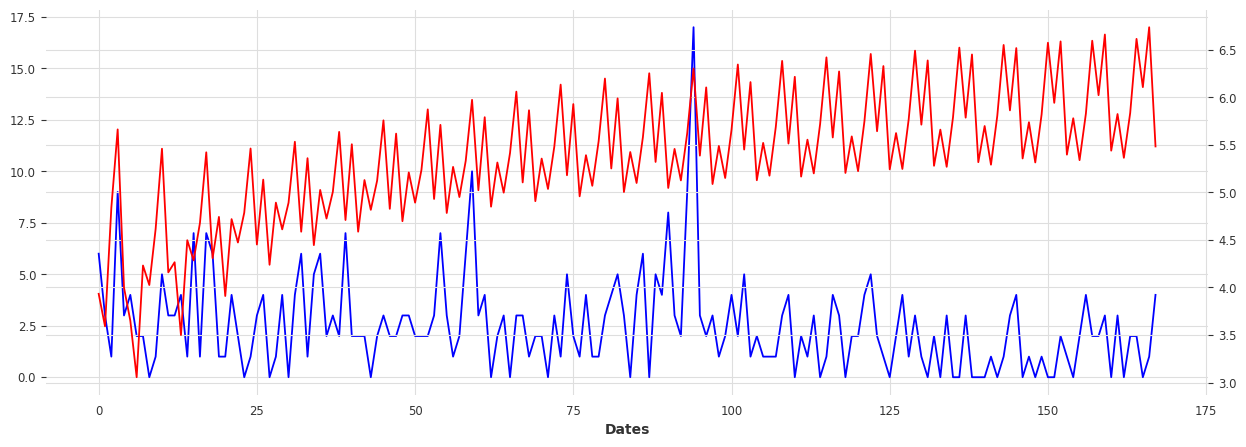

**************************************************

**************************************************
Analysis for: 7
MAPE: 549007203577170.94
MAE: 2.426
SMAPE: 53.27378699457438
R2: 0.01


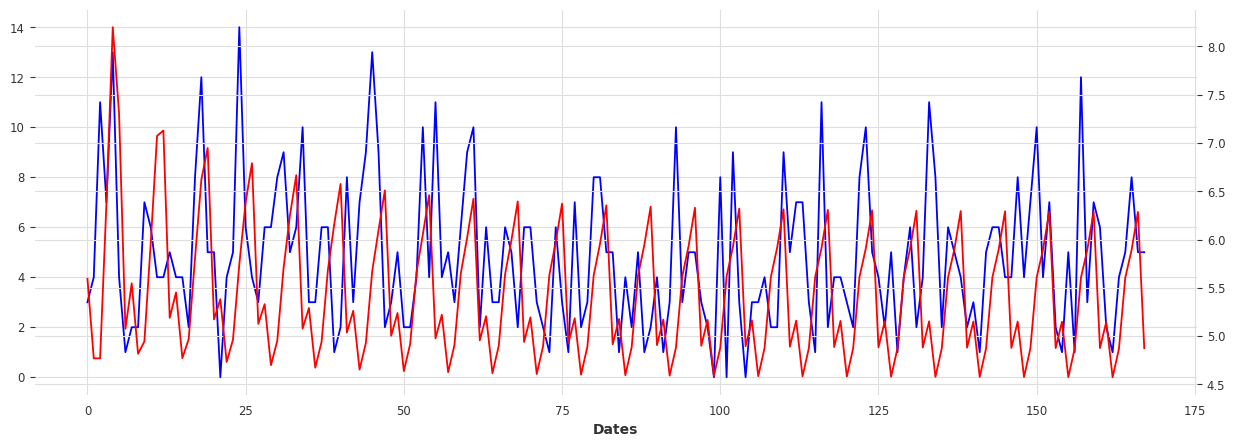

**************************************************



In [ ]:
## Metrics for one series
# Choose TS
list_series_check  = [0, 1, 7]
for id_series in list_series_check:
  print("*"*50)
  print("Analysis for:", id_series)
  # Get metrics
  dct_metrics = pipeline_darts_metrics(
      predictions_univariate=train_pipeline.inverse_transform(forecast, partial=True)[id_series],
      val_darts=train_pipeline.inverse_transform(validation_transformed, partial=True)[id_series],
      list_dates_val=list_dates_val
      )
  print("*"*50)
  print()